# Supplementary Figures for *Luo et al. 2020*

(*A high-resolution HLA reference panel capturing global population diversity enables multi-ethnic fine-mapping in HIV host response*)


**Code for reproducing supplementary figures in the manuscript**

For any question please contact the first author Yang Luo: yangluo@broadinstitute.org

## loading up libraries and presettings

In [29]:
#Load libraries
suppressPackageStartupMessages({
    library(ggplot2)
    library(reshape2)
    library(reticulate)
    library(repr)
    library(patchwork)
    library(plyr)
    library(scales)
    library(RColorBrewer)
    library(dplyr)
    library(data.table)
    library(ggthemes)
    library(ggsci)
    library(rsvd)
    library(tidyr)
    library(ggrepel)
    library(umap)
    library(gridExtra)
    library(cowplot)
    library(plotrix)
    library(ggpubr)
    library(grid)
    library(corrplot)
    library(stringr)
})

In [5]:
# set global plotting parameters
theme_set(theme_bw() + theme(text = element_text(size=20, family = "sans")))

options(repr.plot.width = 10, repr.plot.height = 7)

#pop_colors <- c("black", "#E69F00","#56B4E9","#D55E00","#009E73")
pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#D55E00","#009E73")

pop_labels <- c("Admixed African","East Asian","European","Latino", "South Asian")

#Calc color palette (discrete)
gene_colors <- c("A"="#004586", "B" = "#ff420e", "C"="#ffd320", 
                 "DQA1" = "#579d1c", "DQB1" = "#7e0021", "DRB1" = "#83caff","DPA1" = "#314004", "DPB1" = "#aecf00"  )


## HLA*LA typing accuracy (SF1)

In [69]:
allele.summary <- read.table("../data/Ggroup_allele_summary.txt.gz",h=T,stringsAsFactors = F)

allele.summary$Gene <- sapply(strsplit(allele.summary[,1], "\\*"), "[[", 1)


### Japanese inferred G-group accuracy (N = 288) (SF1a)

[1] 85 13

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”


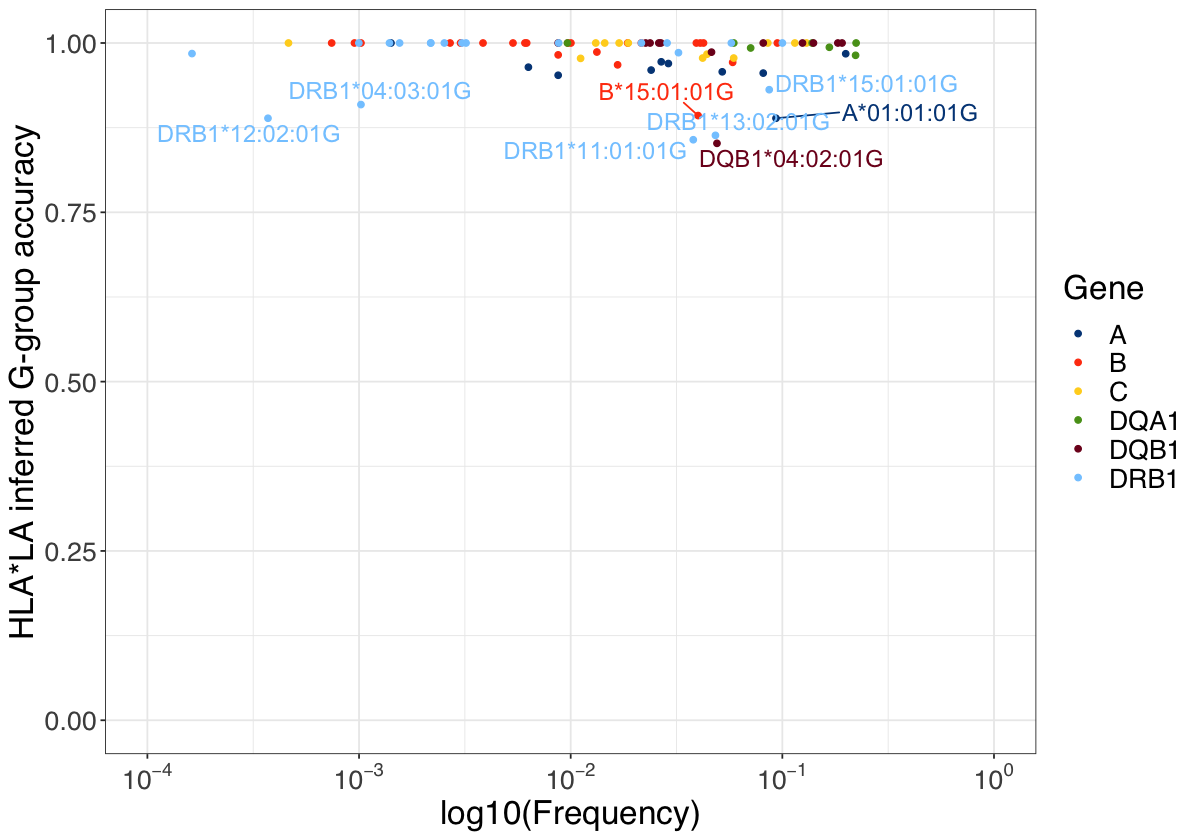

In [6]:
jpn <- allele.summary[!is.na(allele.summary$JPNaccuracy),]
jpn$label <- ifelse(jpn$JPNaccuracy<0.95,jpn$Allele,"")

gold_standard <- read.table("../data/JPN_gold_standard_Ggroups.txt",h=F)
gs.n <- unique(c(gold_standard[,7:22])) %>% unlist() %>% table() %>% as.data.frame()
names(gs.n) <-  c("Allele","n")

jpn$n <- gs.n[match(jpn$Allele,gs.n$Allele),2]
df <- jpn %>% filter(n>=5)
dim(df)
p <- ggplot(df,aes(x=log10(Freq),y=JPNaccuracy,label=label, color=Gene)) + geom_point() 

p <- p + ylab("HLA*LA inferred G-group accuracy") + ylim(0,1)+
 scale_x_continuous(name = "log10(Frequency)",breaks=c(-4,-3, -2, -1,0),limits=c(-4,0),
                       labels=c(expression(10^-4),expression(10^-3),expression(10^-2),expression(10^-1),expression(10^0)))

p + geom_text_repel(size=5, show.legend = FALSE) + scale_colour_manual( values = gene_colors)
ggsave("../figs/SF1a_JPN_HLA_LA_accuracy.pdf",width=10,height=7)

### HLA*LA typing accuracy in 1KG (SF1b)

Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”


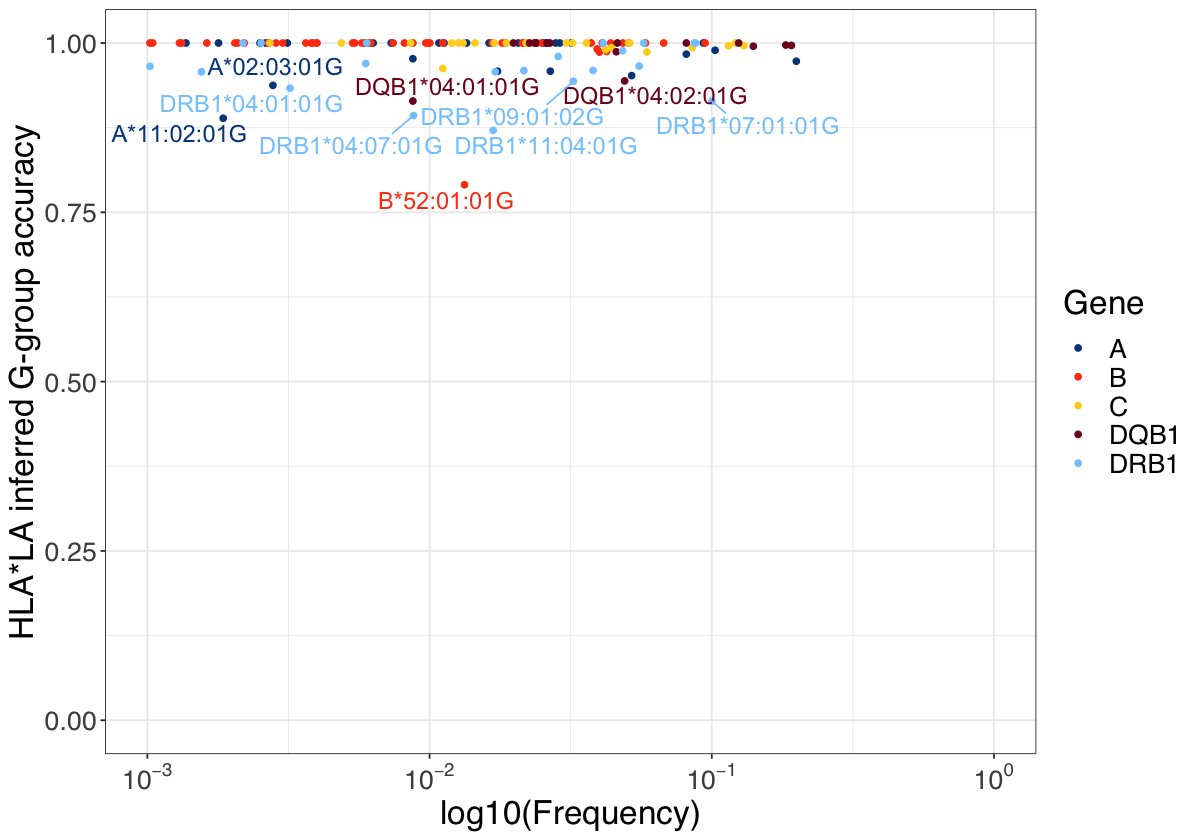

In [9]:
g1k <- allele.summary[!is.na(allele.summary$G1Kaccuracy),]
g1k$label <- ifelse(g1k$G1Kaccuracy<0.95,g1k$Allele,"")

g1k.goldstandard.ggroup <- read.table("../data/G1k_gold_standard_Ggroups.txt",header = T,stringsAsFactors = F)

gs.n <- unique(c(g1k.goldstandard.ggroup[,2:10])) %>% unlist() %>% table() %>% as.data.frame()

names(gs.n) <-  c("Allele","n")

g1k$n <- gs.n[match(g1k$Allele,gs.n$Allele),2]
df <- g1k %>% filter(n>=5)

p <- ggplot(df,aes(x=log10(Freq),y=G1Kaccuracy,label=label, color=Gene)) + geom_point() 

p <- p + ylab("HLA*LA inferred G-group accuracy")+ ylim(0,1) + 
 scale_x_continuous(name = "log10(Frequency)",breaks=c(-3, -2, -1,0),limits = c(-3,0),
                       labels=c(expression(10^-3),expression(10^-2),expression(10^-1),expression(10^0)))

p + geom_text_repel(size=5, show.legend = FALSE) +
    scale_colour_manual(values = gene_colors)

ggsave("../figs/SF1b_G1K_HLA_LA_accuracy.pdf",width=10,height=7)



## 1000G diversity (SF2)

###  PC (SF2a)


In [28]:
## Get data (pairwise IBD using beagle)
ibd <- read.table("../data/deep1000Gibd.txt.gz", row.names = 1, header = T, stringsAsFactors = F)
sampleInfo <- read.table("../data/g1k_samples.txt",header = T, stringsAsFactors = F )
mhc <- ibd[row.names(ibd) %in% sampleInfo$sample,names(ibd) %in% sampleInfo$sample]
mhc_scale <- scale(mhc)
# calculate PCs
mhc.pca <- rsvd(as.matrix(mhc_scale), k=30)
x <- rpca(as.matrix(mhc_scale), k=30)

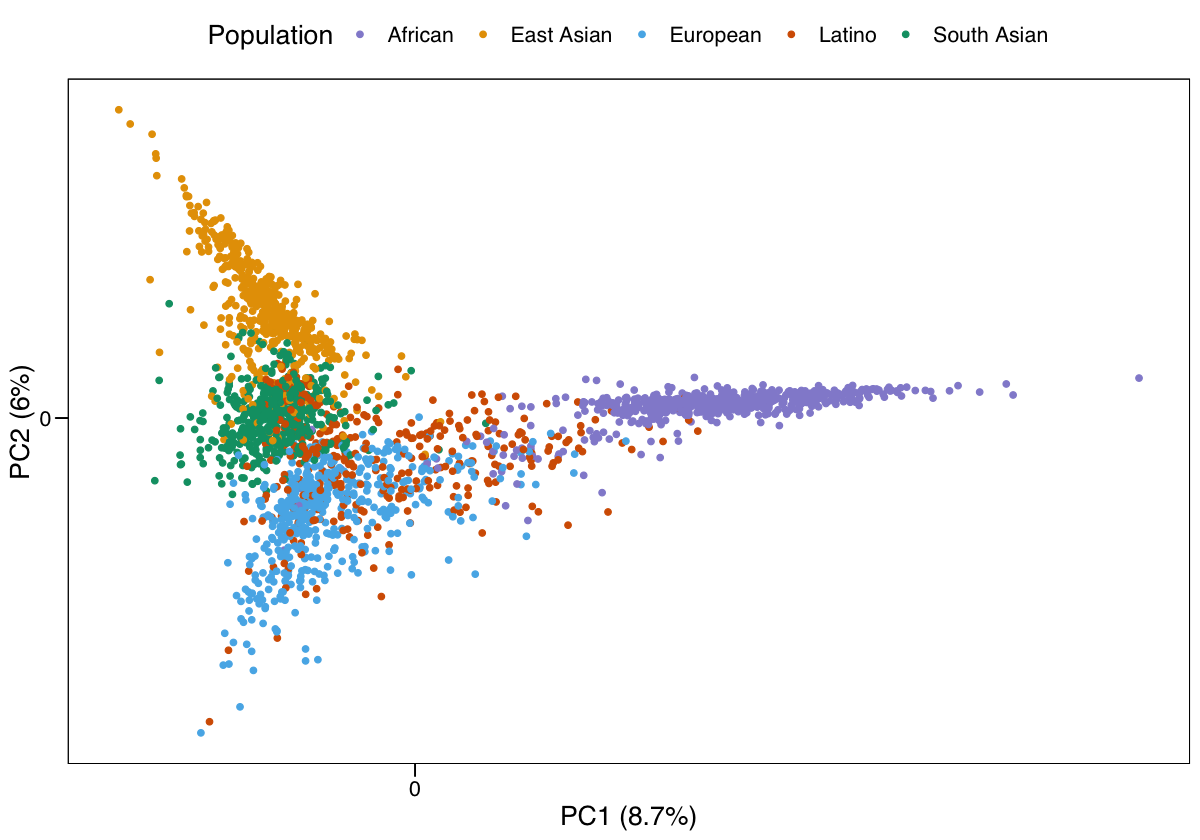

In [36]:
# getting variance explained from rpca function
varexp <- summary(x)[3,1:2]*100

dfplt <- as.data.frame(mhc.pca$u[,1:5])

dfplt$ancestry <- sampleInfo[match(row.names(ibd),sampleInfo$sample),]$super_pop

dfplt[dfplt$ancestry=="AMR",]$ancestry <- "LAT"
g1k.pc.plt <- ggplot(dfplt,aes(V1,V2,colour=ancestry))+geom_point()
g1k.pc.plt <- g1k.pc.plt + scale_color_manual(values = pop_colors,
                                              name="Population",labels=c("African","East Asian","European","Latino","South Asian")) + 
theme_base() +
    xlab(paste("PC1 (",round(varexp[1],2),"%)",sep=""))+ylab(paste("PC2 (",round(varexp[2],2),"%)",sep=""))


g1k.pc.plt <- g1k.pc.plt + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(family = "sans")) 

g1k.pc.plt + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

ggsave(filename = "../figs/SF2a_G1K-PCA.pdf",height=8,width=9)

### UMAP (SF2b)

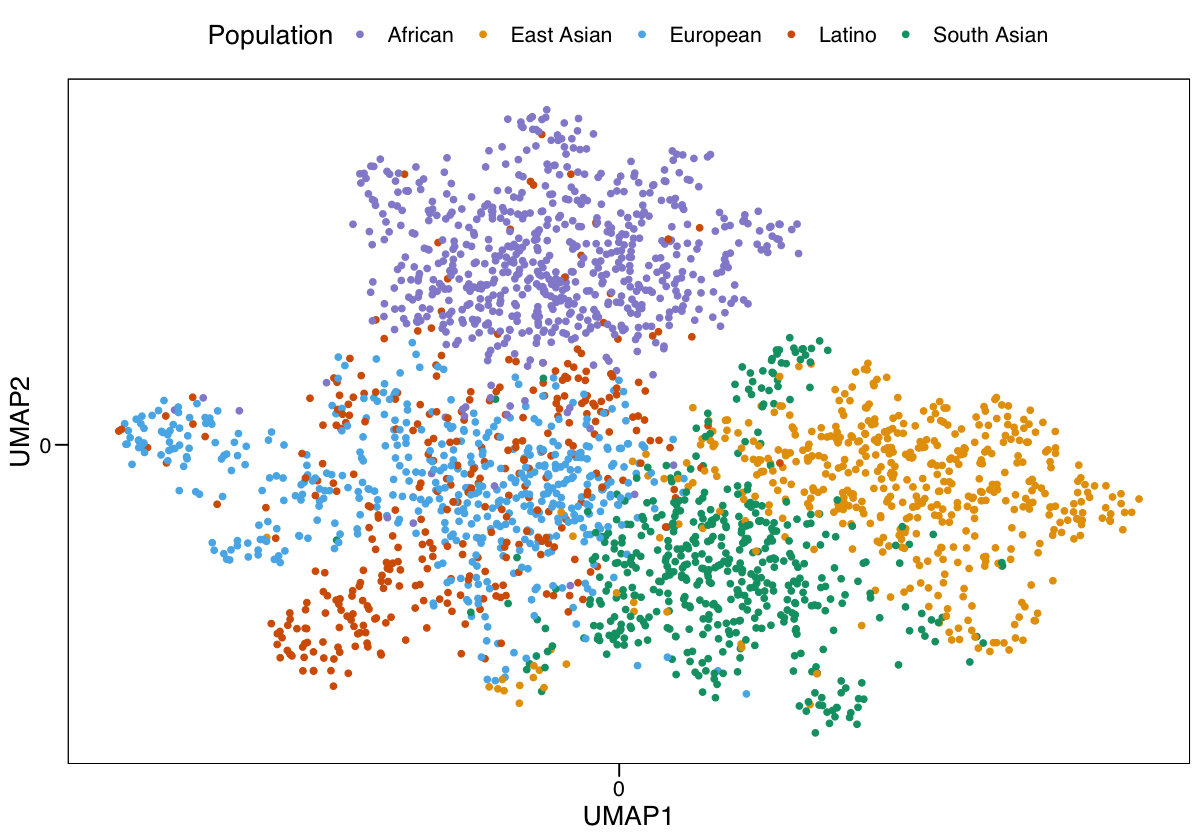

In [15]:
g1k.umap <- umap(mhc_scale,min_dist=0.9,n_neighbors=250)
umap.plt <- data.frame(g1k.umap$layout)

umap.plt $ancestry <- sampleInfo[match(row.names(umap.plt ),sampleInfo$sample),]$super_pop
umap.plt[umap.plt$ancestry=="AMR",] $ancestry <- "LAT"

g1k.umap.plt <- ggplot(umap.plt ,aes(X1,X2,colour=ancestry))+geom_point()
g1k.umap.plt <- g1k.umap.plt + scale_color_manual(values = pop_colors,
                                  name="Population",labels=c("African","East Asian","European","Latino","South Asian")) + 
theme_base() + xlab("UMAP1") + ylab("UMAP2")

g1k.umap.plt <- g1k.umap.plt + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(family = "sans"))
g1k.umap.plt + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

ggsave(filename = "../figs/SF2b_G1K-UMAP.pdf",height=8,width=9)

## G-group diversity (SF3)

In [40]:
dat<-read.table("../data/Ggroups.txt.gz",h=T,sep=" ")
dim(dat)
dat[dat$ethnicity == "missing", ]$ethnicity <- "AFR"
# summary of total ancestry 
table(dat$ethnicity)

# Total number of G-group alleles within each ancestry
ddply(dat,~ethnicity,summarise,count=length(unique(c(A1,A2,B1,B2,C1,C2,DQA11,DQA12,DQB11,DQB12,DRB11,DRB12))))
#head(dat)

[1] 21546    22


    AFR     EAS     EUR     LAT missing     SAS 
   7849    2069   10187     952       0     489 

ethnicity count
1 AFR       323  
2 EAS       247  
3 EUR       307  
4 LAT       256  
5 SAS       184

In [41]:
#creat frequency table

create_table<-function(dat=JPN2,genes=c("A","B","C","DQA1","DQB1","DRB1", "DPA1","DPB1")){
    out<-NULL
    for (gene in genes){
        x<-subset(dat,select=c(paste(gene,"1",sep="")))
        y<-subset(dat,select=c(paste(gene,"2",sep="")))
        df<-na.omit(cbind(x,y))
        frq<-data.frame(table(as.vector(unlist(df[,1:2]),mode='character'))/(nrow(dat)*2))
        frq$Gene<-gene
        out<-rbind(out,frq)
    }
    return(data.frame(out))
}

In [45]:
all <- NULL
frq <- create_table(dat=dat[dat$ethnicity=="LAT",])
frq$Ethnicity<-"LAT"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="EUR",])
frq$Ethnicity<-"EUR"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="AFR",])
frq$Ethnicity<-"AA"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="EAS",])
frq$Ethnicity<-"EAS"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="SAS",])
frq$Ethnicity<-"SAS"
all<-rbind(all,frq)

#head(all)
#define top most frequent alleles
df2<-all %>% group_by(Gene,Ethnicity) %>% top_n(2, Freq) %>% arrange(Gene,Ethnicity,desc(Freq))
others<-setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene, Ethnicity)] 

df3<-rbind(all[all$Var1 %in% df2$Var1,],others)
count<-aggregate(df3$Var1, list(df3$Gene),unique)


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

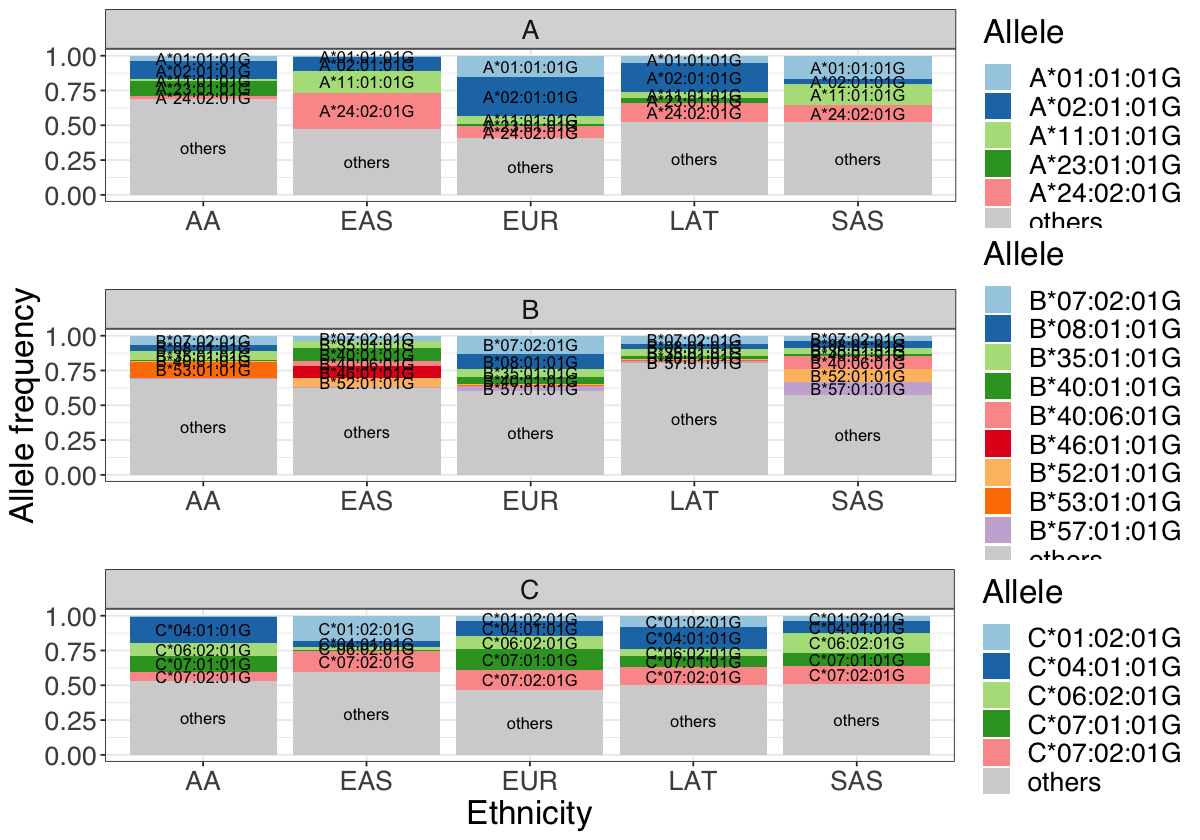

In [48]:
Ggroup <- split(df3, f = df3$Gene)

Ggroup$A$Label <- ifelse(Ggroup$A$Freq > 1e-2,as.character(Ggroup$A$Var1),"")

p1 <- ggplot(Ggroup$A,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey")) + 
    ylab("")+ xlab("")


Ggroup$B$Label <- ifelse(Ggroup$B$Freq > 1e-2,as.character(Ggroup$B$Var1),"")
p2 <- ggplot(Ggroup$B,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:14],"lightgrey"))+
     ylab("Allele frequency") + xlab("")

Ggroup$C$Label <- ifelse(Ggroup$C$Freq > 1e-2,as.character(Ggroup$C$Var1),"")
p3 <- ggplot(Ggroup$C,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[15:19],"lightgrey"))+ ylab("")

p <- grid.arrange(p1, p2,p3 ,ncol=1)
p
ggsave(p,filename = "../figs/SF3_G-group_classI_freq.pdf",width=8,height=11)


TableGrob (5 x 1) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]
4 4 (4-4,1-1) arrange gtable[layout]
5 5 (5-5,1-1) arrange gtable[layout]

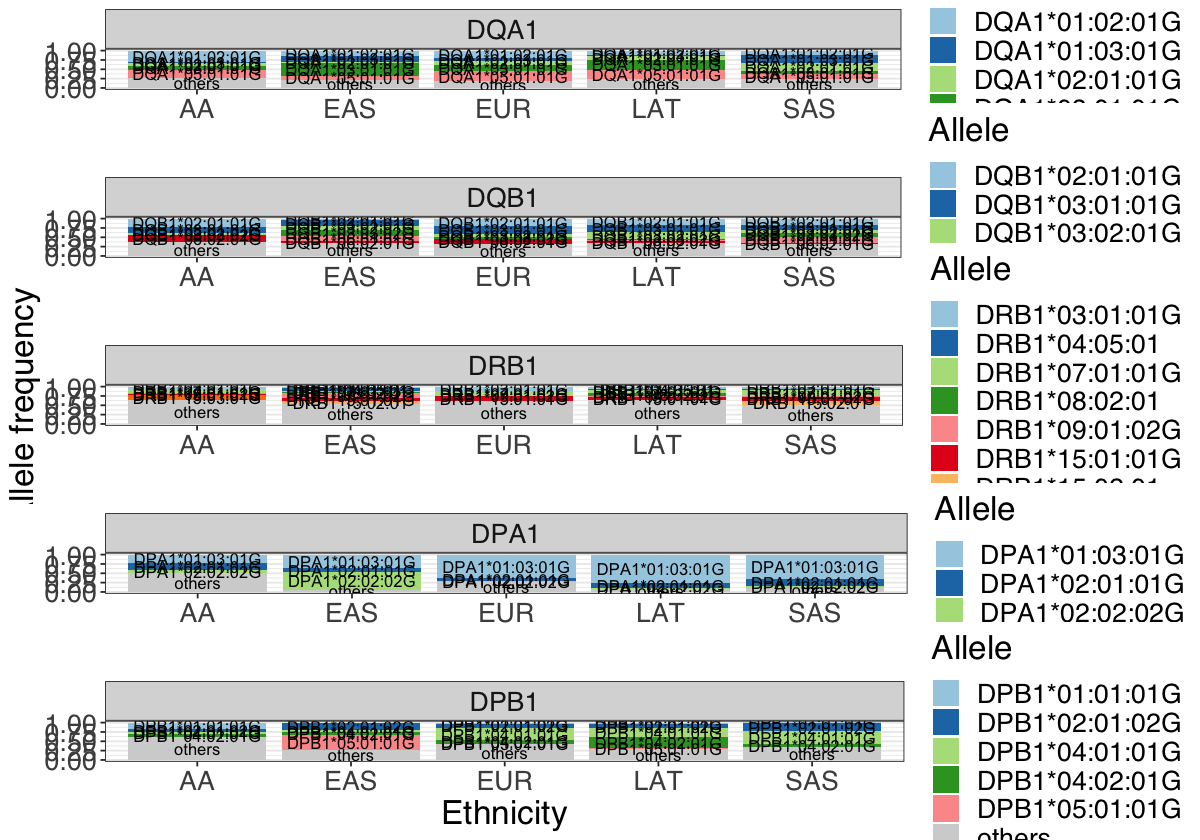

In [50]:
##  Class II
Ggroup <- split(df3, f = df3$Gene)

Ggroup$DQA1$Var1 <- ifelse(Ggroup$DQA1$Var1=="DQA1*02:01","DQA1*02:01:01G",as.character(Ggroup$DQA1$Var1))
Ggroup$DQA1$Label <- ifelse(Ggroup$DQA1$Freq > 1e-2,as.character(Ggroup$DQA1$Var1),"")
p1 <- ggplot(Ggroup$DQA1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey")) + 
    ylab("")+ xlab("")


Ggroup$DQB1$Label <- ifelse(Ggroup$DQB1$Freq > 1e-2,as.character(Ggroup$DQB1$Var1),"")
p2 <- ggplot(Ggroup$DQB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:11],"lightgrey"))+
     ylab("") + xlab("")

Ggroup$DRB1$Label <- ifelse(Ggroup$DRB1$Freq > 1e-2,as.character(Ggroup$DRB1$Var1),"")
p3 <- ggplot(Ggroup$DRB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + xlab("")+
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:13],"lightgrey"))+ ylab("Allele frequency")

Ggroup$DPA1$Label <- ifelse(Ggroup$DPA1$Freq > 1e-2,as.character(Ggroup$DPA1$Var1),"")
p4 <- ggplot(Ggroup$DPA1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:3],"lightgrey"))+ ylab("") + xlab("")
Ggroup$DPB1$Label <- ifelse(Ggroup$DPB1$Freq > 1e-2,as.character(Ggroup$DPB1$Var1),"")
p5 <- ggplot(Ggroup$DPB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey"))+ ylab("")

    
p <- grid.arrange(p1, p2,p3,p4 ,p5,ncol=1)
p
ggsave(p,filename = "../figs/SF3_G-group_classII_freq.pdf",width=12,height=16)


## Heterogeneity of observed common G-group alleles (SF4)

In [51]:
allele.summary <- read.table("../data/Ggroup_allele_summary.txt.gz",h=T,stringsAsFactors = F)
allele.summary$Gene <- sapply(strsplit(allele.summary[,1], "\\*"), "[[", 1)

# alleles show significant difference among population groups (stratified by frequency)

n <- nrow(allele.summary[allele.summary$Freq >= 0.005,])

allele.summary$label <- ifelse(allele.summary$Pval>=0.05/n,allele.summary$Allele,"")
allele.summary[allele.summary$Allele=="B*53:01:01G",]$label <- "B*53:01:01G"
# to make all <10^-300 points to be 300 for plotting
allele.summary$P <- ifelse(-log10(allele.summary$Pval)>=300, 1e-300, allele.summary$Pval)


[1] 175

###  the log10(frequency) of all G-group alleles (SF4a)

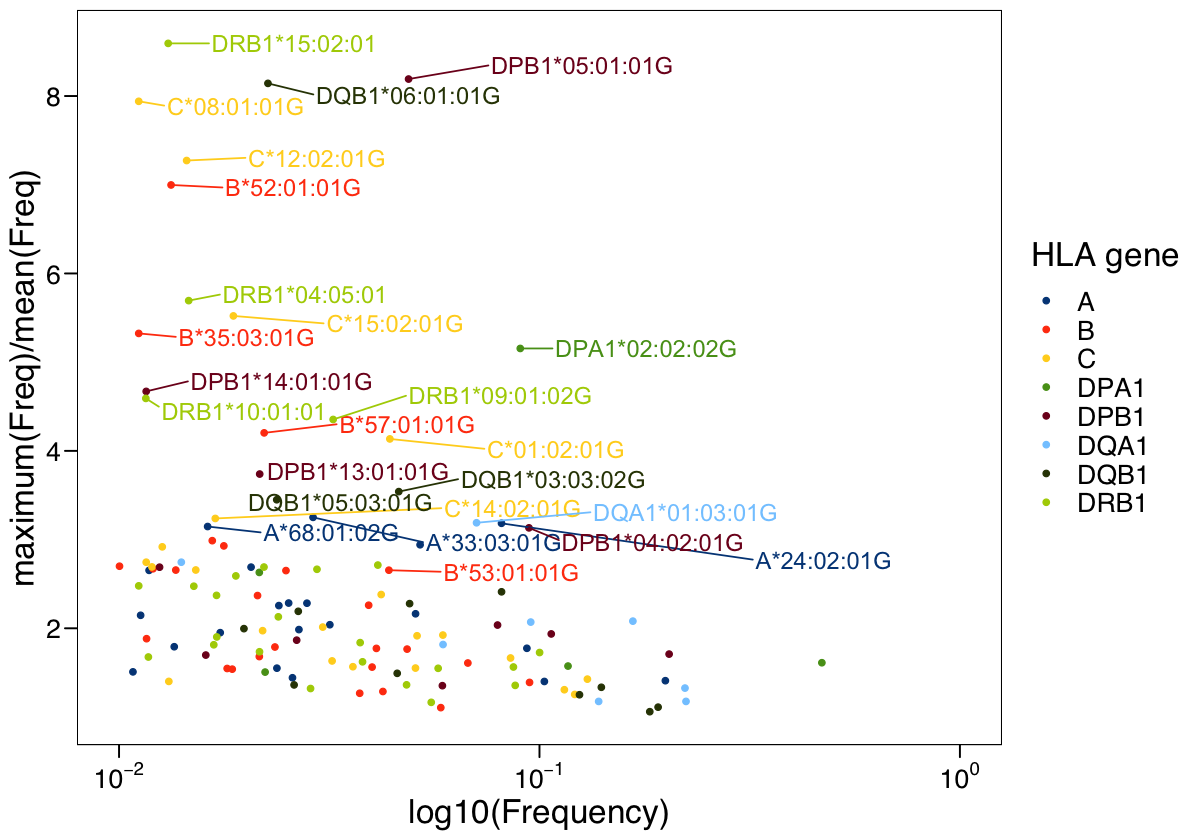

In [56]:
allele.summary[is.na(allele.summary)] <- 0
df <- allele.summary %>% rowwise() %>% mutate(maxFreq=max(EURfreq,AAfreq,LATfreq,SASfreq,EASfreq)) %>%
    mutate(diffFreq = maxFreq/Freq)


df$label <- ifelse(df$diffFreq>3,df$Allele,"")
df[df$Allele=="B*53:01:01G",]$label <- "B*53:01:01G"

p <- ggplot(df %>% filter(Freq>0.01),aes(log10(Freq),diffFreq, color = Gene,
                                                     label=label))+geom_point() + theme_base()  

p <- p + scale_x_continuous(name = "log10(Frequency)",breaks=c(-2, -1, 0),
                       labels=c(expression(10^-2),expression(10^-1),expression(10^0)),
                            limits = c(-2,0))

p <- p + theme(plot.background=element_blank(),
                        text = element_text(size=20, family = "sans")) +
 scale_y_continuous(name = "maximum(Freq)/mean(Freq)") 


p + scale_colour_calc(name="HLA gene") + geom_text_repel(segment.size  = .5,nudge_x = 0.3,
                                                         size=5, show.legend = FALSE) 

ggsave("../figs/SF4a_Ggroup_maxvsmeanfreq_by_freq.pdf",width=10,height=7)

### the -log10(P-value) of chi-square statistics obtained from a 3x5  contingency table (SF4b)

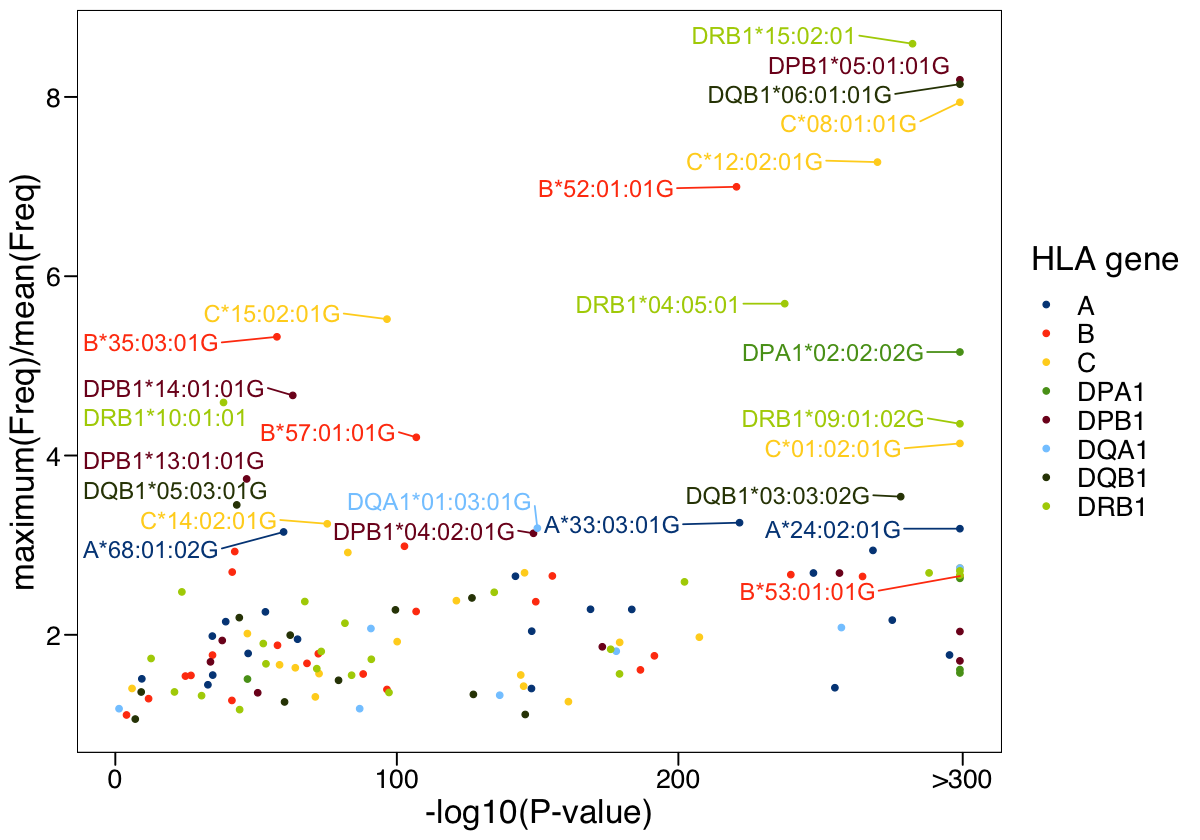

In [55]:
p <- ggplot(df %>% filter(Freq>0.01),aes(-log10(P),diffFreq, color = Gene,
                                                     label=label))+geom_point() + theme_base()  


p <- p + theme(plot.background=element_blank(),
                        text = element_text(size=20, family = "sans")) +
 scale_y_continuous(name = "maximum(Freq)/mean(Freq)") +
 scale_x_continuous(name = "-log10(P-value)",breaks=c(0,100,200,301),labels = c(0,100,200,">300")) 



p + scale_colour_calc(name="HLA gene") + geom_text_repel(segment.size  = .5, nudge_x = -45,
                                                         size=5,show.legend = FALSE) 

ggsave("../figs/SF4b_Ggroup_maxvsmeanfreq_by_pval.pdf",width=10,height=7)


## Number of observed G-group alleles (SF5)

[1] 1532   13

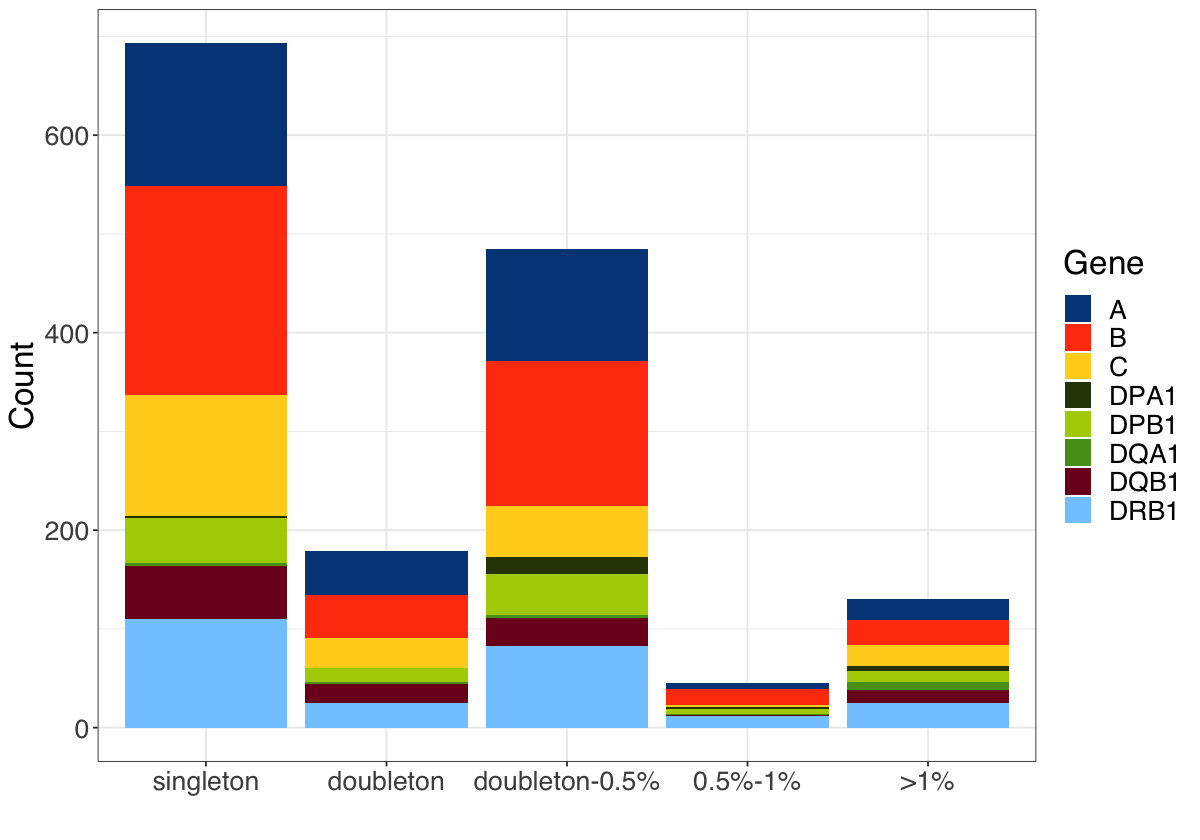

In [57]:
n <- 21546 # totoal number of individuals

freq.bin <- c(0,1/n/2,1/n,0.005,0.01,1)

x <- allele.summary %>%
  group_by(group = cut(Freq, breaks = freq.bin))
dim(allele.summary)

count.df <- x %>% group_by(group,Gene) %>% count(group)

p <- ggplot(count.df,aes(x=group, y=n, fill=Gene)) + geom_bar(stat='identity') +
    theme_bw() + xlab("") + ylab("Count")

p +  scale_x_discrete(labels=c("singleton", "doubleton",
                               "doubleton-0.5%","0.5%-1%",">1%")) +
    theme(text = element_text(size=20, family = "sans")) +  scale_fill_manual(values = gene_colors)

ggsave('../figs/SF6_Ggroup_freq_count.pdf',width=10,height=7)


## Overall G-group diversity in eight HLA genes (SF6)

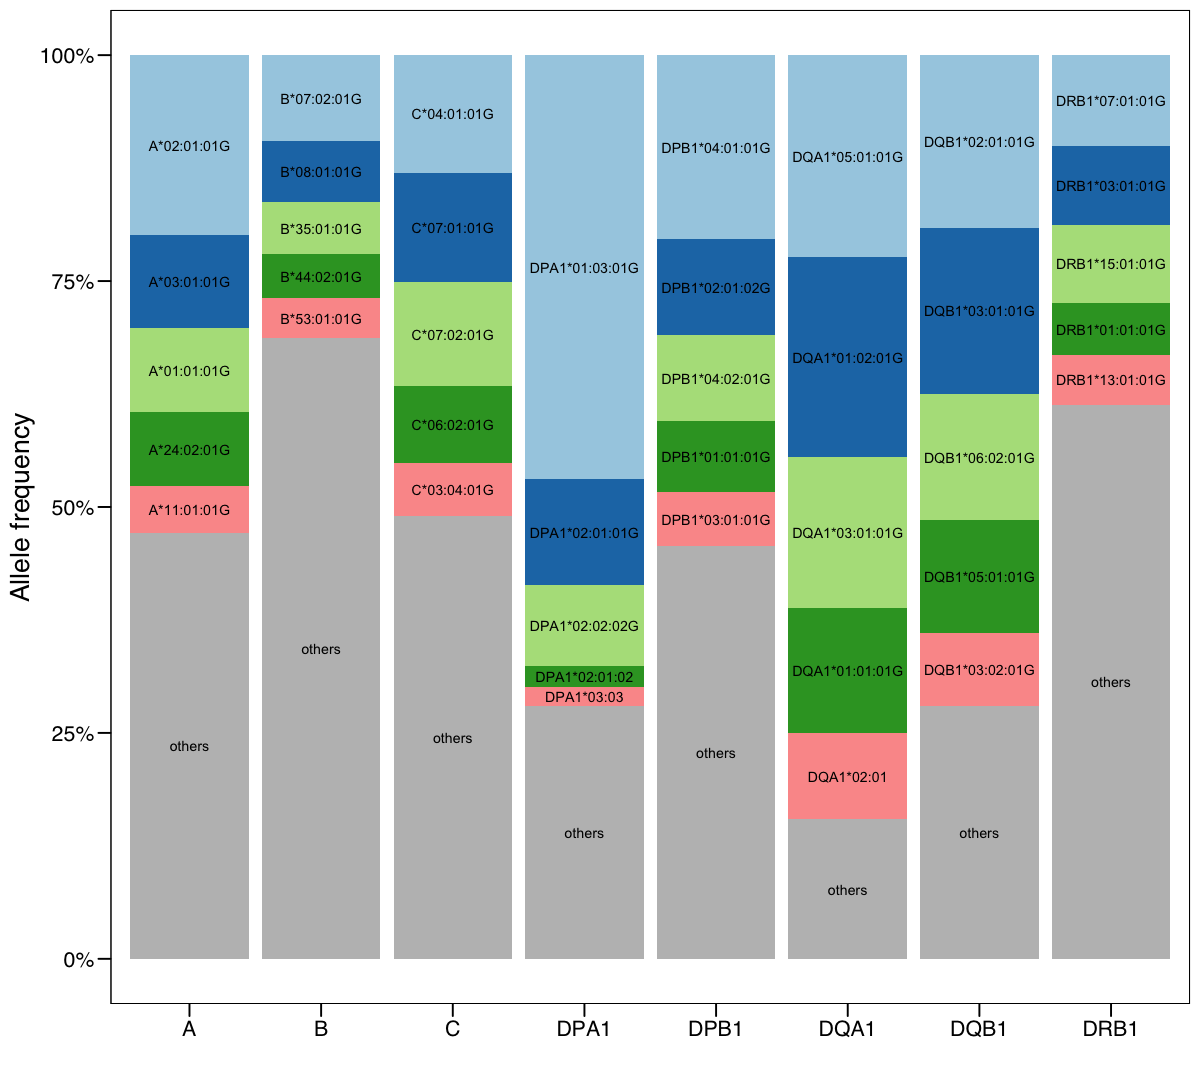

In [59]:
Ggroup<-read.table("../data/Ggroups.txt.gz",h=T,sep=" ")
Ggroup[Ggroup$ethnicity == "missing", ]$ethnicity <- "AFR"
Ggroup$ethnicity <- factor(Ggroup$ethnicity)

all <- create_table(dat=Ggroup[!is.na(Ggroup$ethnicity),])

#define top most frequent alleles
n <- 5
df2 <- all %>% group_by(Gene) %>% top_n(n, Freq) %>% arrange(Gene,desc(Freq))
others <- setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene)] %>% arrange(Gene,desc(Freq))
others$order <- n+1

df3 <- df2 %>% group_by(Gene) %>% arrange(Gene,desc(Freq))
df3$order <- rep(c(1:n),8)


df4 <- rbind(data.frame(df3),data.frame(others[,names(df3)]))

freq.plt <- ggplot(df4,aes(x=Gene,y=Freq,fill=as.factor(order)))+geom_bar(stat='identity')+scale_y_continuous(label=percent)+
    geom_text(aes(label=Var1), position=position_stack(vjust = 0.5), size=3)
freq.plt <- freq.plt + theme_base()+theme(legend.position = "none" ) + scale_fill_manual(values=c(brewer.pal(5,"Paired"),"grey"))

options(repr.plot.width = 10, repr.plot.height = 9)


freq.plt <- freq.plt + xlab("") + ylab("Allele frequency")

freq.plt  <- freq.plt +  theme(legend.position="none",
                        plot.background=element_blank(),
                        text = element_text(family = "sans"))
freq.plt
ggsave(filename = "../figs/SF6-freq.pdf",width=10,height=7)

## Pairwise LD measurement index (SF7)

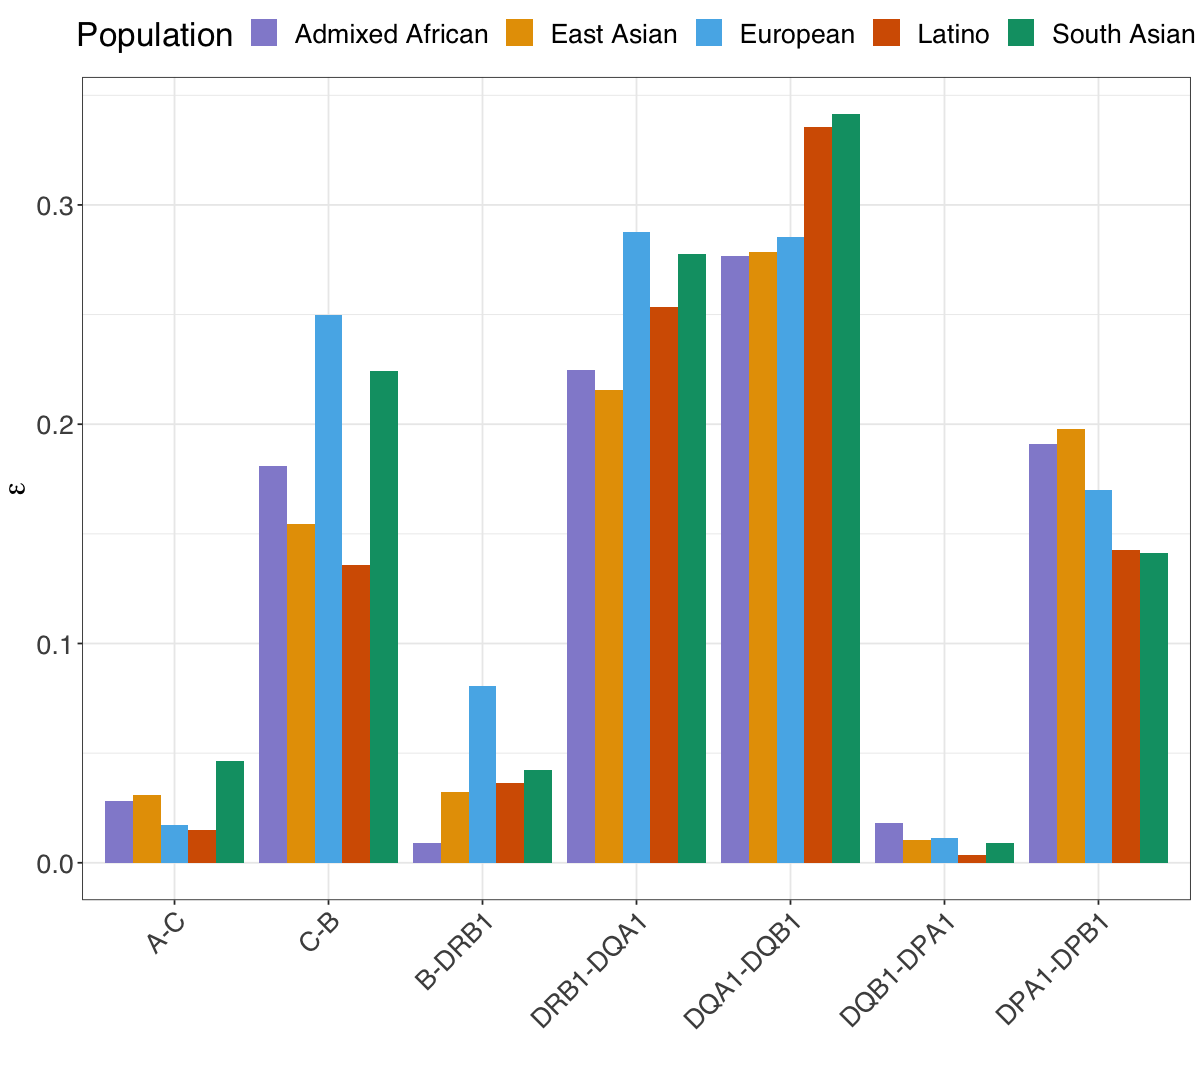

In [63]:
epsilon <- NULL
pop <- "AA"
    M<-read.table(paste("../data/",pop,"_eps.txt",sep=""),h=T,stringsAsFactors = F)
    for (i in 1:7){
        epsilon <- c(epsilon, M[i+1,i])
    }
    epsilon <- as.data.frame(epsilon)
    epsilon$gene <- c("A-C","C-B","B-DRB1","DRB1-DQA1","DQA1-DQB1","DQB1-DPA1","DPA1-DPB1")

    names(epsilon)[1] <- pop

for (pop in c("EAS","EUR","LAT","SAS")){
    M<-read.table(paste("../data/",pop,"_eps.txt",sep=""),h=T,stringsAsFactors = F)
    X<- NULL
    for (i in 1:7){
        X <- c(X, M[i+1,i])
    }
    epsilon <- cbind(X, epsilon)

    names(epsilon)[1] <- pop
}

df.plt <- epsilon %>% gather(variable, value, -gene)
df.plt$gene <- factor(df.plt$gene, levels=c("A-C","C-B","B-DRB1","DRB1-DQA1","DQA1-DQB1","DQB1-DPA1","DPA1-DPB1"))
p <- ggplot(df.plt,aes(x=gene,y=value,fill=variable)) + geom_bar(stat = "identity", position=position_dodge())

p <- p + xlab("")+ylab(expression(epsilon)) + 
scale_fill_manual("Population",labels = pop_labels, values = pop_colors)

p + theme(axis.text.x=element_text(angle=45, hjust=1),legend.position="top")
ggsave("../figs/SF7_epsilon_pairs.pdf",width=10,height=7)


## MESA PCA (SF13)

In [66]:
yy<-read.table("../data/MESA.predpc",h=F,stringsAsFactors = F)
df <- data.frame(yy)
eigenval<-scan("../data/MESA.eigenval",as.numeric())
val<-eigenval/sum(eigenval)*100

In [67]:
# classify ancestry based on projected PCs:
df$Ethnicity <- NA
df[df$V5 > 0.057,]$Ethnicity <- "European"
df[df$V4 > 0.028,]$Ethnicity <- "Asian"
#df[(df$V4 < 0.002 ) ,]$Ethnicity<-"African American"
df[df$V4>0.002 & df$V4< 0.028 & df$V5< 0.057,]$Ethnicity<-"Latino"
df[is.na(df$Ethnicity),]$Ethnicity <- "African American"
#re-classifying some other points
df[df$Ethnicity=="African American" & df$V6<0.4 & df$V5 <0.025,]$Ethnicity <- "Latino"
#df[df$Ethnicity=="African American" & df$V5 < 0.0 & df$V4 > -0.04,]$Ethnicity <- "Latino"
df[df$Ethnicity=="African American" & df$V4 > 0.0 & df$V5 < 0.03,]$Ethnicity <- "Latino"
df[df$Ethnicity=="Latino" & df$V4 < -0.005 & df$V5 > -0.001,]$Ethnicity <- "African American"


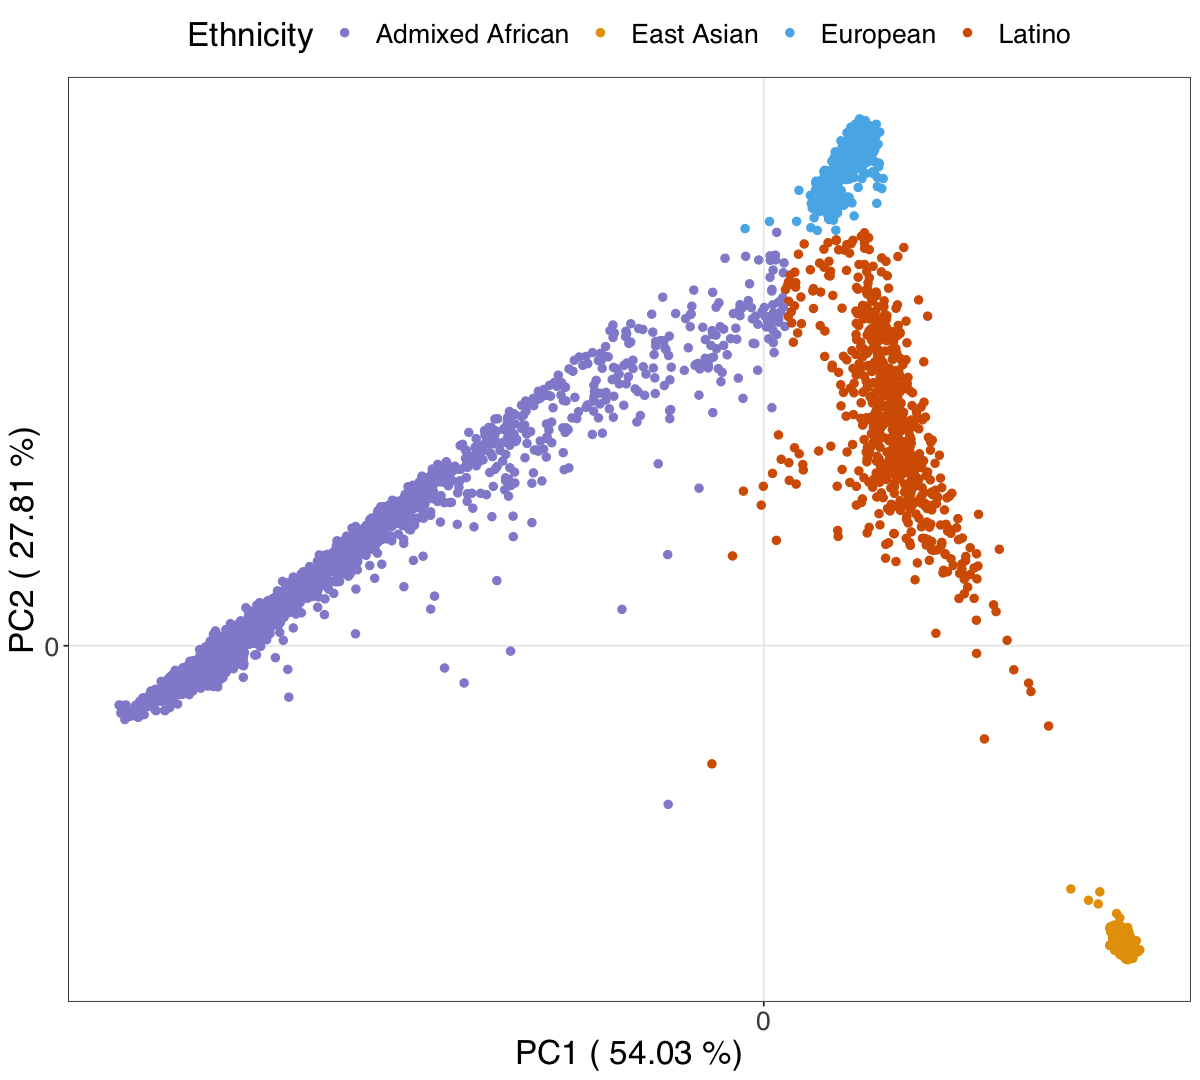

In [68]:
mesaPCs <- ggplot(na.omit(df),aes(x=V4,y=V5,colour=Ethnicity))+geom_point(size=2)+
  xlab(paste("PC1 (",round(val[1],2),"%)"))+ylab(paste("PC2 (",round(val[2],2),"%)"))+
  scale_color_manual(values=pop_colors,
                     labels=pop_labels)
mesaPCs <- mesaPCs + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(family = "sans")) 

mesaPCs + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)
ggsave("../figs/SF13_MESA-PCA.pdf", height = 8, width = 8)

## MHC selection (SF14)

In [9]:
admix = read.table("../data/g1k-mesa-prunedALL.4.Q")
fam = read.table("../data/g1k-mesa-prunedALL.fam")
g1k_label =read.table("../data/integrated_call_samples_v3.20130502.ALL.panel",header=T,stringsAsFactors = F)
fam$superpop = g1k_label[match(fam$V1, g1k_label$sample),"super_pop"]

# load inferred MESA info
MESA_AA.sample = read.table("../data/MESA_AA_samples.txt",stringsAsFactors = F)
MESA_AMR.sample = read.table("../data/MESA_Latino_samples.txt", stringsAsFactors = F)

fam$superpop[fam$V1 %in% MESA_AA.sample$V1] ="MESA_AA"
fam$superpop[fam$V1 %in% MESA_AMR.sample$V1] ="MESA_AMR"


In [10]:
# For Admixed Africans (AA), column 2 is EUR, column 1 is NAT, column 3 is AFR 
MESA_AA_AFR_global_mean = 2*mean(admix[fam$superpop=="MESA_AA",3],na.rm = TRUE)
MESA_AA_AFR_global_sd = 2*sd(admix[fam$superpop=="MESA_AA",3],na.rm = TRUE) 
MESA_AA_EUR_global_mean = 2*mean(admix[fam$superpop=="MESA_AA",2],na.rm = TRUE)
MESA_AA_EUR_global_sd = 2*sd(admix[fam$superpop=="MESA_AA",2],na.rm = TRUE)



In [11]:
# For Latinos (AMR), column 2 is EUR, column 1 is NAT, column 3 is AFR 
MESA_AMR_AFR_global_mean = 2*mean(admix[fam$superpop=="MESA_AMR",3],na.rm = TRUE)
MESA_AMR_AFR_global_sd = 2*sd(admix[fam$superpop=="MESA_AMR",3],na.rm = TRUE) 
MESA_AMR_EUR_global_mean = 2*mean(admix[fam$superpop=="MESA_AMR",2],na.rm = TRUE)
MESA_AMR_EUR_global_sd = 2*sd(admix[fam$superpop=="MESA_AMR",2],na.rm = TRUE)


### selection in AA (SF14a)

In [12]:
##rfmix AA 
AA_dose= read.table("../data/MESA_AA_subset_rfmix.dose.gz",h=T)
colnames(AA_dose)=c("chromosome","physical_position","genetic_position","genetic_marker_index","AFR","EUR")
AA_dose_mean =mean(AA_dose$AFR)
AA_dose_sd = sd(AA_dose$AFR)

In [13]:
#elai AA
AA_elai =read.table("../data/MESA_AA_new_0402.ps21.txt.gz")
AA_snp = read.table("../data/MESA_AA_new_0402.snpinfo.txt",header=T)
AA_elai_AFR = colMeans(AA_elai[, seq(2,127946,2)])
AA_elai_mean = mean(AA_elai_AFR)

In [14]:
rfmix.plt <- AA_dose
rfmix.plt$average <- scale(AA_dose$AFR) + AA_dose_mean - MESA_AA_AFR_global_mean

rfmix.plt %>%  filter(physical_position>=28*1e6 & physical_position <= 34*1e6) %>% 
  select(average) %>% colMeans()

elai.plt <- cbind(AA_snp,average=scale(AA_elai_AFR)+ AA_elai_mean - MESA_AA_AFR_global_mean)
elai.plt %>%  filter(pos>=28*1e6 & pos <= 34*1e6) %>% 
  select(average) %>% summarise(mean.average = mean(average,na.rm=T),
                                sd.average = sd(average,na.rm=T),
                                n.average = n()) %>%
              mutate(se.average = sd.average / sqrt(n.average),
                     lower.ci.average = mean.average - qt(1-(0.05/2),n.average -1)* se.average,
                     uppper.ci.average = mean.average + qt(1-(0.05/2),n.average -1)* se.average)


average 
1.560842

mean.average sd.average n.average se.average lower.ci.average
1 3.419453     1.209388   1141      0.03580328 3.349206        
  uppper.ci.average
1 3.489701

In [15]:
# outside MHC
df<- cbind(AA_snp,AA_elai_AFR)
x <- df %>%  filter(pos<28*1e6 |pos > 34*1e6) %>% 
  select(AA_elai_AFR) 
mean(as.vector(unlist(x)))/2

# inside MHC
x <- df %>%  filter(pos>=28*1e6 &pos <= 34*1e6) %>% 
  select(AA_elai_AFR) 
mean(as.vector(unlist(x)))/2

[1] 0.7449104

[1] 0.7802313

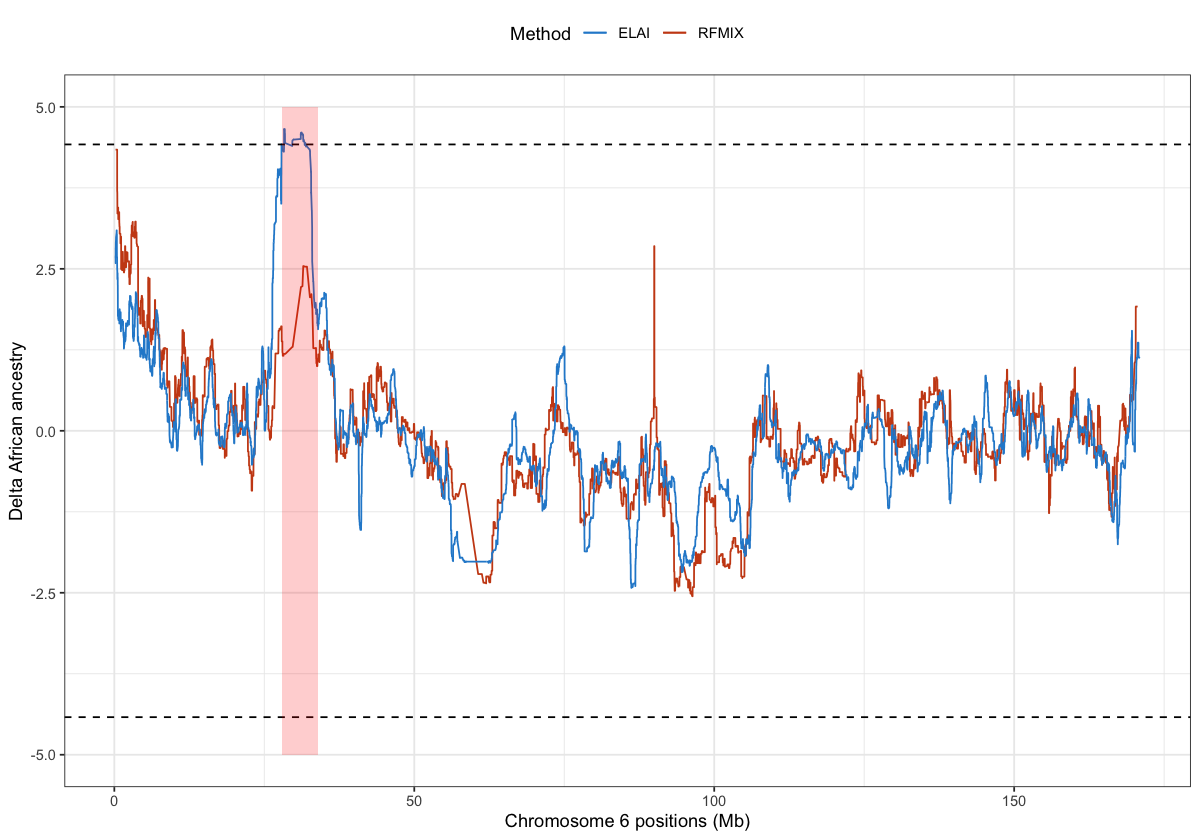

In [17]:
ggplot()+ geom_line(data=rfmix.plt, aes(x=physical_position/1e6, y=scale(average), color="rfmix" ))+
  geom_line(data= AA_snp, aes(x=pos[pos>1e5]/1e6, y=scale(AA_elai_AFR)+ AA_elai_mean - MESA_AA_AFR_global_mean, color="ELAI"))+
  geom_hline(yintercept = 4.42 , color="black", linetype="dashed")+
  geom_hline(yintercept = - 4.42 , color="black", linetype="dashed")+
#  geom_hline(yintercept = 0 , color="black", linetype="dashed")+
  annotate("rect", xmin=28000000/1e6, xmax=34000000/1e6, ymin=-5, ymax=5, alpha=0.2, fill="red") +
  ylab("Delta African ancestry") + theme_bw() + xlab("Chromosome 6 positions (Mb)")+
  scale_color_manual(name="Method",labels=c("ELAI","RFMIX"),values=c("#268bd2", "#cb4b16"))+
  theme(legend.position = "top")

ggsave("../figs/SF14a_MESA-AA-selection.pdf", height = 8, width = 12)

### selection in Latios (SF14b)

In [18]:
##rfmix AMR
AMR_dose= read.table("../data/MESA_AMR_subset_rfmix.dose.gz",header=T)
AMR_dose_mean =mean(AMR_dose$AFR)
AMR_dose_sd = sd(AMR_dose$AFR)

## elai AMR
AMR_elai =read.table("../data/MESA_Latinos_3way_0402.ps21.txt.gz")
AMR_snp = read.table("../data/MESA_Latinos_3way_0402.snpinfo.txt",header=T)
AMR_elai_AFR = colMeans(AMR_elai[, seq(2,191994,3)])
AMR_elai_mean = mean(AMR_elai_AFR)
AMR_elai_sd = sd(AMR_elai_AFR)

In [19]:
elai.AMR.plt <- cbind(AMR_snp,average=scale(AMR_elai_AFR)+ AMR_elai_mean - MESA_AMR_AFR_global_mean)

elai.AMR.plt %>%  filter(pos>=28*1e6 & pos <= 34*1e6) %>% 
  select(average) %>% summarise(mean.average = mean(average,na.rm=T),
                                sd.average = sd(average,na.rm=T),
                                n.average = n()) %>%
  mutate(se.average = sd.average / sqrt(n.average),
         lower.ci.average = mean.average - qt(1-(0.05/2),n.average -1)* se.average,
         uppper.ci.average = mean.average + qt(1-(0.05/2),n.average -1)* se.average)


# outside MHC
df<- cbind(AMR_snp,AMR_elai_AFR)
x <- df %>%  filter(pos<28*1e6 |pos > 34*1e6) %>% 
  select(AMR_elai_AFR) 
mean(as.vector(unlist(x)))/2

# inside MHC
x <- df %>%  filter(pos>=28*1e6 &pos <= 34*1e6) %>% 
  select(AMR_elai_AFR) 
mean(as.vector(unlist(x)))/2




mean.average sd.average n.average se.average lower.ci.average
1 4.232002     1.456116   1149      0.0429572  4.147719        
  uppper.ci.average
1 4.316285

[1] 0.05761976

[1] 0.1598449

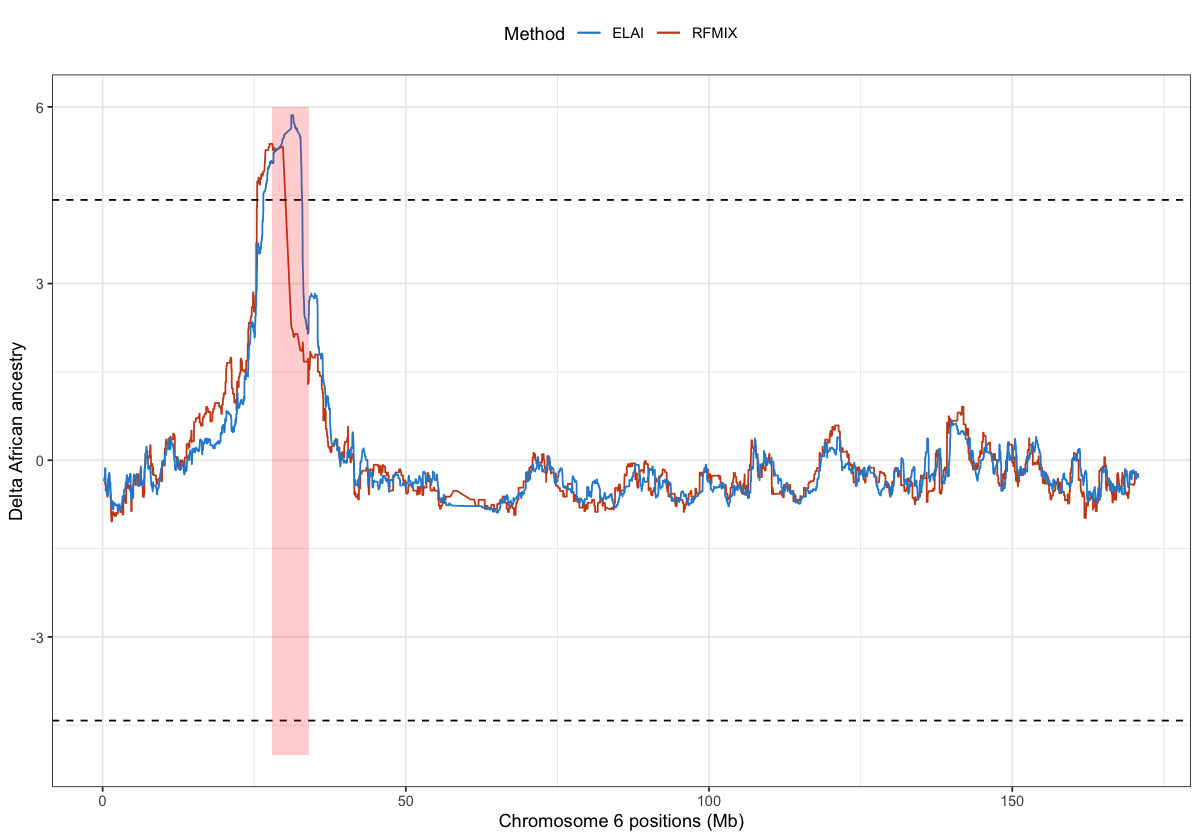

In [20]:
ggplot()+ geom_line(data=AMR_dose, aes(x=physical_position/1e6,scale(AFR), color="rfmix" ))+
  geom_line(data= AMR_snp, aes(x=pos[pos>1e5]/1e6, y=scale(AMR_elai_AFR), color="ELAI"))+
  geom_hline(yintercept = 4.42 , color="black", linetype="dashed")+
  geom_hline(yintercept = - 4.42 , color="black", linetype="dashed")+
  #  geom_hline(yintercept = 0 , color="black", linetype="dashed")+
  annotate("rect", xmin=28000000/1e6, xmax=34000000/1e6, ymin=-5, ymax=6, alpha=0.2, fill="red") +
  ylab("Delta African ancestry") + theme_bw() + xlab("Chromosome 6 positions (Mb)")+
  scale_color_manual(name="Method",labels=c("ELAI","RFMIX"),values=c("#268bd2", "#cb4b16")) + 
  theme(legend.position = "top")

ggsave("../figs/SF14b_MESA-LAT-selection.pdf", height = 8, width = 12)

## GAP PCA (SF15)

In [23]:
gap.pc <- data.frame(read.table("../data/GAPPCs.eigenvec", header = F, stringsAsFactors = F))

sampleInfo <- read.table("../data/g1k_samples.txt",header = T, stringsAsFactors = F )

gap.pc$Ethnicity <- sampleInfo[match(gap.pc$V2,sampleInfo$sample),]$super_pop
gap.pc[is.na(gap.pc$Ethnicity),]$Ethnicity <- "zgap"

selectedGAP <- scan("../data/gap_validation_samples.txt",as.character())

gap.pc$selected <- ifelse(gap.pc$V2 %in% selectedGAP,1,0)

gap.pc[gap.pc$selected==1,]$Ethnicity <- "zgap_picked"
sum(gap.pc$selected)

table(gap.pc$Ethnicity)
pop_labels
gap.pc$Ethnicity <- factor(gap.pc$Ethnicity, levels = c("AFR","EAS","EUR","AMR","SAS","zgap","zgap_picked"))

[1] 75


        AFR         AMR         EAS         EUR         SAS        zgap 
        661         347         504         503         489        2163 
zgap_picked 
         75 

[1] "Admixed African" "East Asian"      "European"        "Latino"         
[5] "South Asian"

In [25]:
GAP.pc.plt <- ggplot(gap.pc,aes(x=V3,y=V4,color=Ethnicity))+
    geom_point(data = gap.pc %>% filter(Ethnicity != "zgap"),  alpha = 0.6)+
    geom_point(data = gap.pc %>% filter(Ethnicity == "zgap"),  alpha = 0.4) +
    geom_point(data = gap.pc %>% filter(selected == 1),  alpha = 1, color="red") +
  xlab("PC1")+ylab("PC2") 

GAP.pc.plt <- GAP.pc.plt +
  scale_color_manual(name = "",values=c(pop_colors[c(1,4,2,3,5)],"pink","red"),
                     labels=c(pop_labels[c(1,4,2,3,5)],"GAP GWAS", "Selected GAP samples"))
GAP.pc.plt <- GAP.pc.plt + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(family = "sans")) 

gap.pc12 <- GAP.pc.plt + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

GAP.pc.plt <- ggplot(gap.pc,aes(x=V3,y=V5,color=Ethnicity))+
    geom_point(data = gap.pc %>% filter(Ethnicity != "zgap"),  alpha = 0.6)+
    geom_point(data = gap.pc %>% filter(Ethnicity == "zgap"),  alpha = 0.4) +
    geom_point(data = gap.pc %>% filter(selected == 1),  alpha = 1, color="red") +
  xlab("PC1")+ylab("PC3") +
  scale_color_manual(name = "",values=c(pop_colors[c(1,4,2,3,5)],"pink","red"),
                     labels=c(pop_labels[c(1,4,2,3,5)],"GAP GWAS", "Selected GAP samples"))
GAP.pc.plt <- GAP.pc.plt + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(family = "sans")) 

gap.pc13 <- GAP.pc.plt + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

mylegend<-g_legend(gap.pc12)

prow <- plot_grid( gap.pc12 + theme(legend.position="none"),
           gap.pc13 + theme(legend.position="none"),
           align = 'vh',
           labels = c("(a)", "(b)"),
           hjust = -1,
           nrow = 1
           )
pdf("../figs/SF15_GAP-PCA.pdf", height = 7, width = 10)

    
p <- plot_grid( mylegend, prow,  ncol = 1, rel_heights = c( .2,1))
p
dev.off()

pdf 
  2

## GaP imputation accuracy (SF16)

## HIV imputation dosage r2 (SF17)

In [26]:
r2 <- read.table("../data/r2_summary.txt.gz",h=T,stringsAsFactors = F, comment.char = "#")

hiv <- r2 %>% select(allele,HIV_r2,HIV_freq) %>% na.omit()

In [33]:
# assign resolutions
hiv$num <- unlist(sapply(hiv$allele,function(x) str_count(x, ":")) )                   
hiv$resolution <- NA

hiv$resolution <- ifelse(hiv$num>=2,"G-group",hiv$resolution)
hiv$resolution <- ifelse(hiv$num==1,"two-field",hiv$resolution)
hiv$resolution <- ifelse(hiv$num==0,"one-field",hiv$resolution)


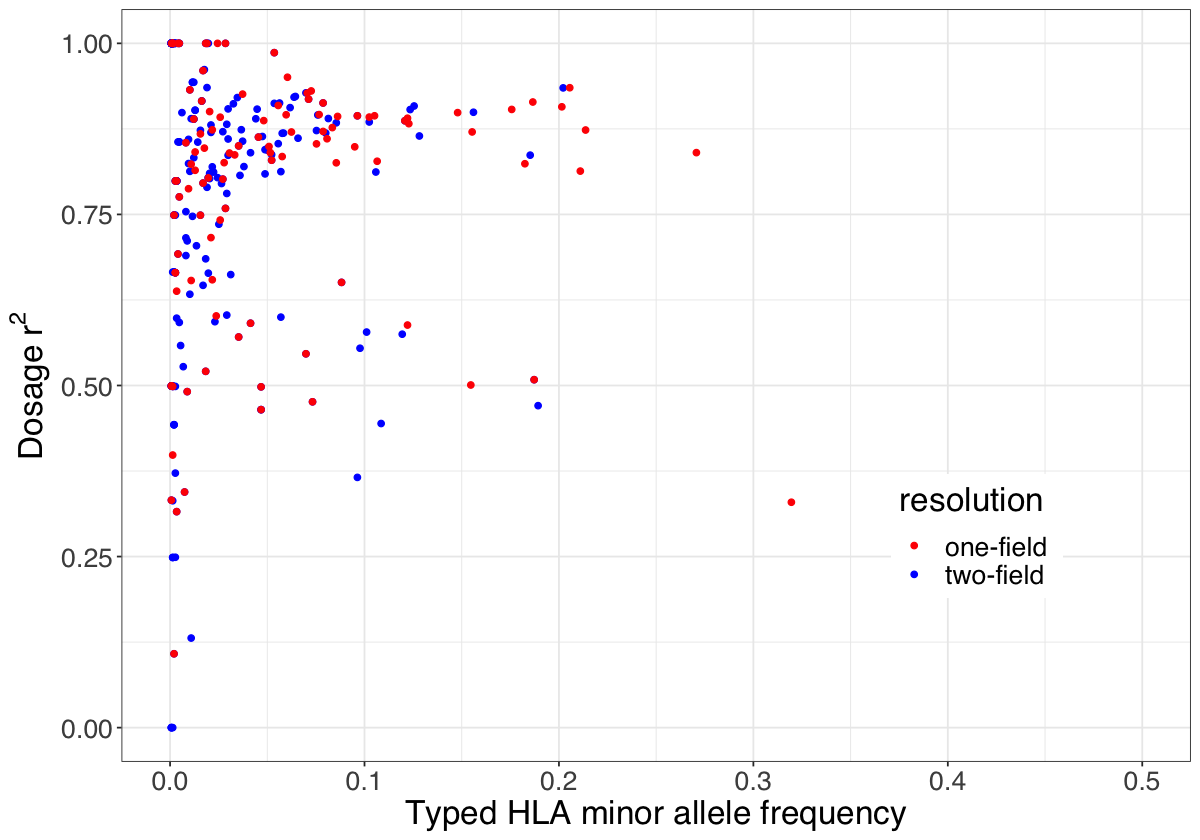

In [37]:
hiv$resolution <- factor(hiv$resolution, levels = c("one-field","two-field","G-group"))

ggplot(hiv %>% filter(resolution!="G-group"),aes(HIV_freq,HIV_r2,col=resolution)) + 
geom_point()  +
xlim(0,0.5) + ylim(0,1) + 
    xlab("Typed HLA minor allele frequency") + ylab(expression("Dosage"~r^2)) +
    scale_color_manual(values=c("red","blue"),
                      labels = c("one-field","two-field")) +
    theme(legend.position=c(0.8,0.3))

#ggsave(,filename = "../figs/Fig3b_dosage_r2.pdf",width=6,height=6)


In [39]:
hiv %>% filter(resolution!="G-group" & HIV_r2 <0.5)

allele     HIV_r2       HIV_freq     num resolution
1  B*14:03    4.993207e-01 0.0006784261 1   two-field 
2  DPB1*18:01 4.646937e-01 0.0468113976 1   two-field 
3  A*30:03    1.846054e-06 0.0006784261 1   two-field 
4  C*04:13    4.426298e-01 0.0020352782 1   two-field 
5  A*30:04    4.426298e-01 0.0020352782 1   two-field 
6  B*14:03    4.993207e-01 0.0006784261 1   two-field 
7  B*15:18    4.993207e-01 0.0013568521 1   two-field 
8  B*35:08    1.846054e-06 0.0006784261 1   two-field 
9  B*41:01    2.486413e-01 0.0013568521 1   two-field 
10 C*02:02    1.309014e-01 0.0108548168 1   two-field 
11 C*08:01    4.993207e-01 0.0013568521 1   two-field 
12 C*12:02    2.486413e-01 0.0013568521 1   two-field 
13 DQB1*02:01 3.656940e-01 0.0963364993 1   two-field 
14 DQB1*03:01 4.444164e-01 0.1085481682 1   two-field 
15 DQB1*06:01 3.315193e-01 0.0013568521 1   two-field 
16 DRB1*04:03 2.489810e-01 0.0027137042 1   two-field 
17 DRB1*12:02 4.986395e-01 0.0027137042 1   two-field 
18 DPB1*02:01 4.761475e-01 0.0732700136 1   two-field 
19 DPB1*18:01 4.646937e-01 0.0468113976 1   two-field 
20 DPB1*40:01 3.443253e-01 0.0074626866 1   two-field 
21 DPB1*14:01 3.156322e-01 0.0033921303 1   two-field 
22 DQA1*01:02 4.705194e-01 0.1892808684 1   two-field 
23 DQA1*03:01 4.980055e-01 0.0468113976 1   two-field 
24 DQA1*06:01 3.324275e-01 0.0006784261 1   two-field 
25 A*30:03    1.846054e-06 0.0006784261 1   two-field 
26 B*57:04    4.993207e-01 0.0006784261 1   two-field 
27 C*04:13    4.426298e-01 0.0020352782 1   two-field 
28 DPB1*39:01 1.079397e-01 0.0020352782 1   two-field 
29 DPB1*85:01 4.910221e-01 0.0088195387 1   two-field 
30 DPB1*06:01 4.986395e-01 0.0013568521 1   two-field 
31 DPB1*15:01 4.986395e-01 0.0013568521 1   two-field 
32 DPB1*20:01 4.993207e-01 0.0006784261 1   two-field 
33 DPB1*28:01 4.993207e-01 0.0006784261 1   two-field 
34 DQB1*06:11 7.404322e-06 0.0013568521 1   two-field 
35 DQB1*06:08 3.719332e-01 0.0027137042 1   two-field 
36 DPB1*02    4.761475e-01 0.0732700136 0   one-field 
37 DPB1*18    4.646937e-01 0.0468113976 0   one-field 
38 DPB1*40    3.443253e-01 0.0074626866 0   one-field 
39 DPB1*14    3.156322e-01 0.0033921303 0   one-field 
40 DQA1*01    3.293905e-01 0.3195386703 0   one-field 
41 DQA1*03    4.980055e-01 0.0468113976 0   one-field 
42 DQA1*06    3.324275e-01 0.0006784261 0   one-field 
43 DPB1*39    1.079397e-01 0.0020352782 0   one-field 
44 DPB1*85    4.910221e-01 0.0088195387 0   one-field 
45 DPB1*06    4.986395e-01 0.0013568521 0   one-field 
46 DPB1*15    3.983673e-01 0.0013568521 0   one-field 
47 DPB1*20    4.993207e-01 0.0006784261 0   one-field 
48 DPB1*28    4.993207e-01 0.0006784261 0   one-field

## Effect of 97Val (SF19)

Warning message:
“Ignoring unknown aesthetics: width”
Warning message:
“Removed 1 rows containing missing values (geom_crossbar).”
Warning message:
“Removed 1 rows containing missing values (geom_crossbar).”


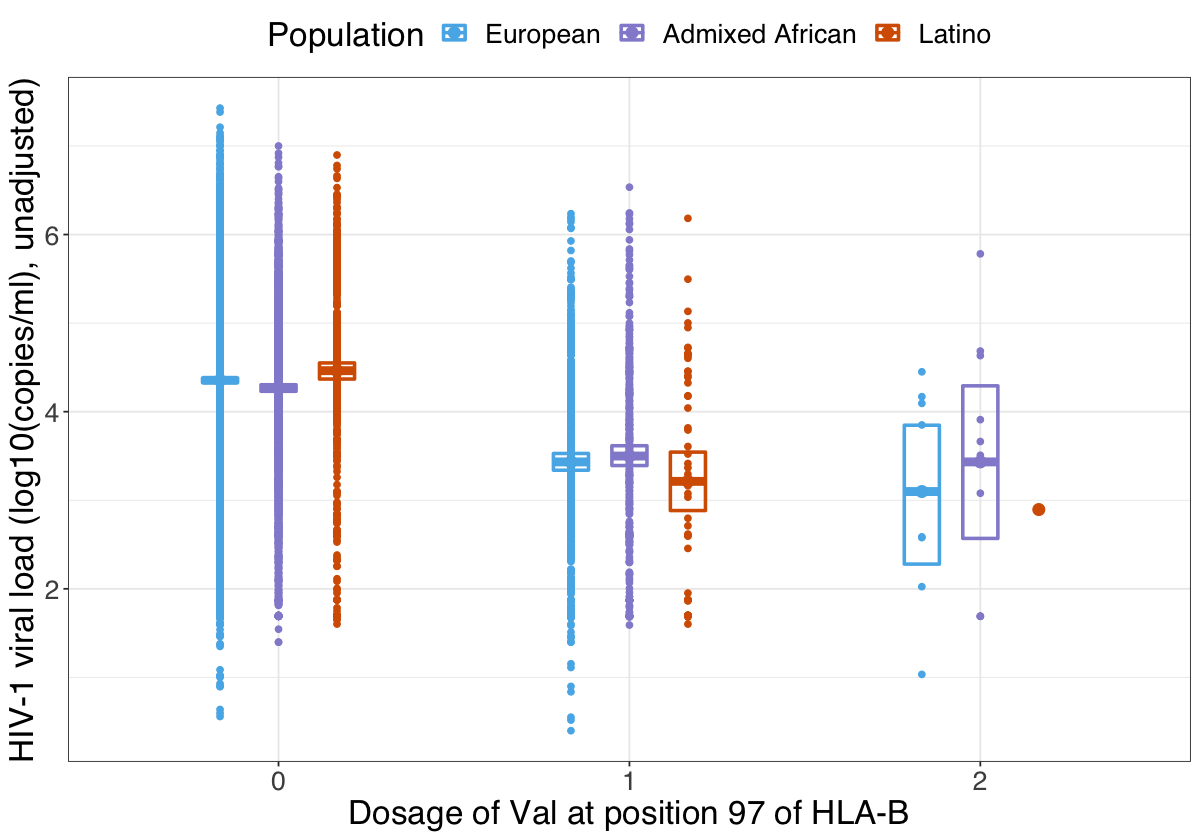

In [48]:
eur <- read.table("..//data/EUR.raw",h=T,stringsAsFactors = F)
aa <- read.table("../data/AFR.raw",h=T,stringsAsFactors = F)
lat <- read.table("../data/LAT.raw",h=T,stringsAsFactors = F)

eur[,9] <- 2-eur[,9] # different minor allele for R
names(eur)[9]<- names(aa)[9]
df <- rbind(cbind(eur,pop="EUR"),cbind(aa,pop="AA"),cbind(lat,pop="LAT"))

plt.df <- df %>% select(colnames(df)[!grepl("HET",colnames(df))]) %>% filter(PHENOTYPE!=-9) 
names(plt.df)[7:12]<-c("N","R","S","T","V","W")

p <- ggplot(plt.df %>% select("PHENOTYPE","V","pop"), aes(x=as.factor(V), y=PHENOTYPE)) +
    ylab("HIV-1 viral load (log10(copies/ml), unadjusted)") + xlab("Dosage of Val at position 97 of HLA-B")+
theme(legend.position="top") 


p_point <- p + geom_point(position = position_dodge(.5),aes(color=pop))
p_point <- p_point  + stat_summary(fun.data = mean_cl_boot, geom = "crossbar", aes(width=0.3,colour = pop), size=1,position=position_dodge(0.5)) + 
  stat_summary(fun.y = mean, geom = "point", aes(colour = pop),size=3,position=position_dodge(0.5))



p_point <- p_point +  scale_colour_manual(values=pop_colors[c(3,1,4)],
                          labels=pop_labels[c(3,1,4)],
                    name = "Population")  

p_point
ggsave(p_point, filename="../figs/SF19_97V_dosage.png", height = 7, width = 8)


## spVL of position 97 in HLA-B (SF20)

In [40]:
tidyData <- function(pop="eur",haplo = read.table("../data/haplo.1.txt",sep=",",h=F,stringsAsFactors = F )){
  # read in data
  fname <- paste("../data/",pop,".3.phased.gz",sep="")
  x<-read.table(fname,h=F,stringsAsFactors = F)
  sample <- scan(paste("../data/",pop,".header",sep=""),as.character())
  phenoALL <- read.table(paste("../data/",pop,".pheno",sep = ""),h=F,stringsAsFactors = F)
  pheno <- phenoALL %>% filter(V1 %in% sample) %>% filter(V3!=-9)
  plt.df <- NULL
  for (i in c(1:nrow(haplo))){
    geno <- t(x[x[,2] %in% haplo[i,],])
    
    resString <- unlist(strsplit(haplo[i,],"_"))[6]
    #print(resString)
    plt.df <- rbind(plt.df,data.frame(sample=pheno$V1,vl=pheno$V3,res=resString,
                                      present=ifelse(pheno$V1 %in% sample[rowSums(geno == "T") == 1],1,0),
                                      pop=pop)
    )
  }
  return(plt.df)
}

In [41]:
plt.df <- rbind(tidyData(pop="aa"),
                tidyData(pop="eur"),
                tidyData(pop="lat"))

Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”


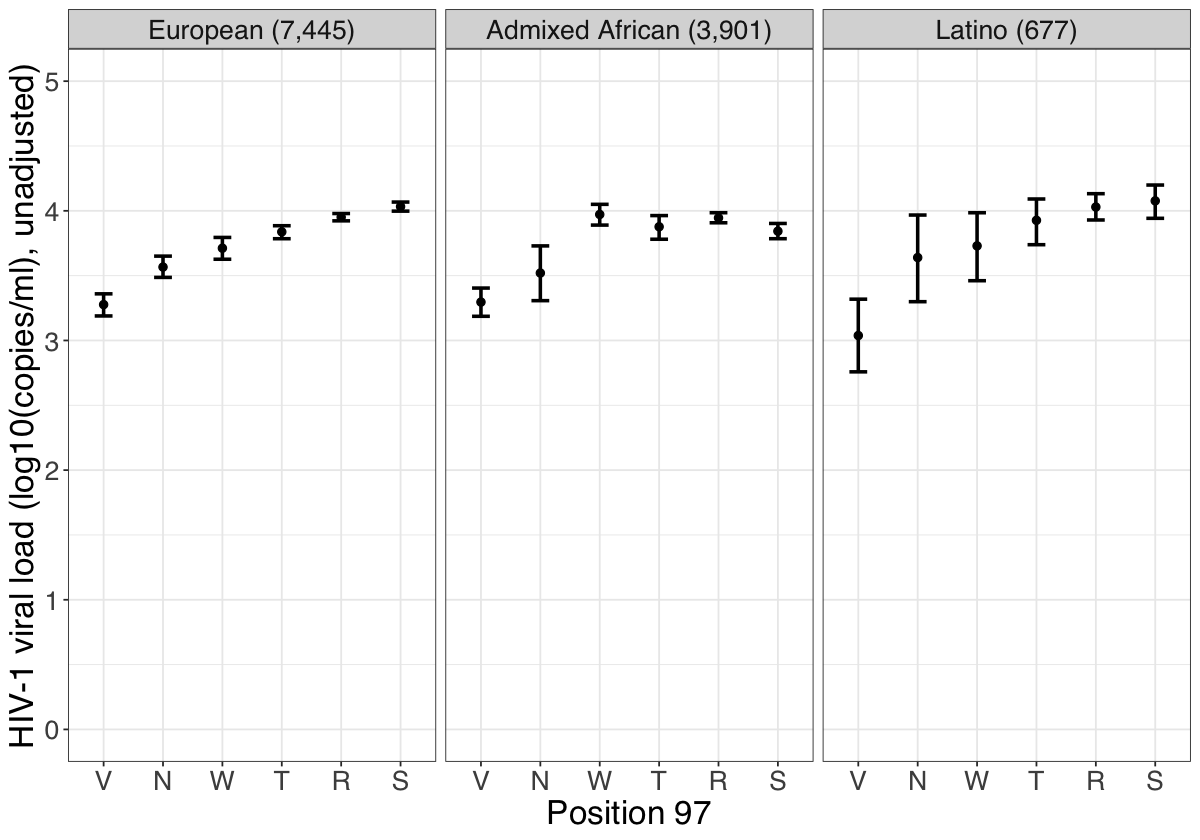

In [43]:
plt.df$pop <- factor(plt.df$pop,levels=c("eur","aa","lat"))
p <- ggplot(plt.df %>% filter(present==1), 
            aes(reorder(res,vl,FUN=median),y=vl)) 
p <- p  + stat_summary(fun.data = mean_cl_boot, geom = "errorbar", aes(width=0.3),colour = "black", size=1) + 
  stat_summary(fun.y = mean, geom = "point", colour = "black",size=2)

# New facet label names for populations
pop.labs <- c("Admixed African (3,901)", "European (7,445)","Latino (677)")

names(pop.labs) <- c("aa", "eur","lat")
p <- p + facet_grid(~pop,labeller = labeller(pop=pop.labs))  + ylim(0,5)

p + theme(axis.text.x = element_text(angle = 0, hjust = 0.5)) + 
  xlab("Position 97") + ylab("HIV-1 viral load (log10(copies/ml), unadjusted)")

ggsave("../figs/SF20_spVL97.pdf",width=10,height=6)


## reported amino acid frequencies (SF21)

Warning message in melt(df):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(df). In the next version, this warning will become an error.”
Using pos as id variables



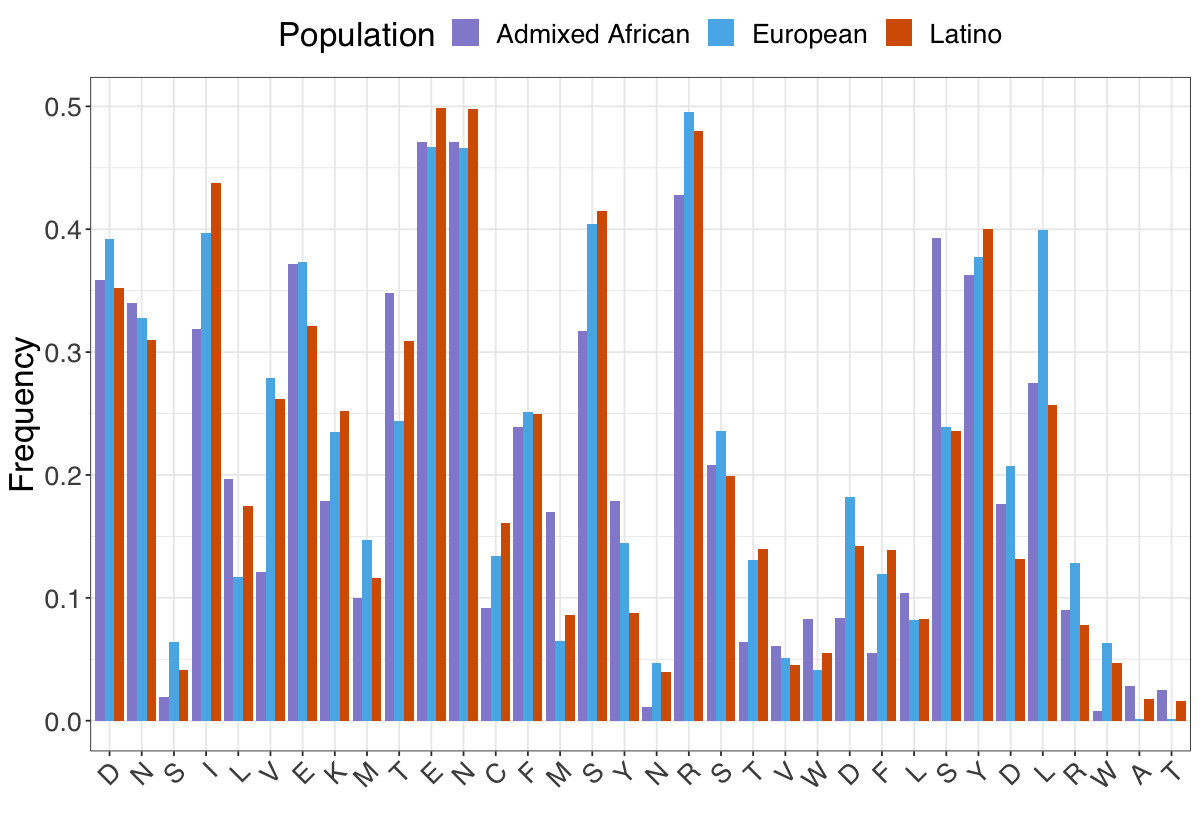

In [49]:
frq <-read.table("../data/HIV_AA_freqs.txt",h=T,stringsAsFactors = F)

df <- data.frame(pos=paste(frq$gene,frq$residue,frq$amino_acid,sep="-"),
                 AA=frq$AA,EUR=frq$EUR,LAT=frq$LAT)

plt.df <- melt(df)

plt.df$pos <- factor(plt.df$pos,levels = levels(plt.df$pos)[c(1:6,18:35,7:17)])

xlabels <- c(frq[frq$residue==77,3],frq[frq$residue==95,3],
                      frq[frq$residue==45,3],frq[frq$residue==63,3],
                      frq[frq$residue==67,3],frq[frq$residue==97,3],
                      frq[frq$residue==116,3],frq[frq$residue==156,3],frq[frq$residue==245,3])


plt.frq <- ggplot(plt.df,aes(x=pos,y=value,fill=variable))+
  geom_bar(stat ="identity", position = "dodge") +
  scale_fill_manual(values=pop_colors[c(1,3,4)],
                          labels=pop_labels[c(1,3,4)],
                    name = "Population")

plt.frq <- plt.frq + theme(axis.text.x=element_text(angle=45, hjust=1),legend.position="top") +
  ylab("Frequency") + xlab("") 

plt.frq + scale_x_discrete(labels=xlabels)

ggsave("../figs/SF21_hiv_res_freq.pdf",width=15,height=8)

## spVL of all haplotypes (SF22)

In [51]:
tidyData <- function(pop="eur",haplo = read.table("../data/haplo.3.txt",sep=",",h=F,stringsAsFactors = F )){
  # read in data
  fname <- paste("../data/",pop,".3.phased.gz",sep="")
  x<-read.table(fname,h=F,stringsAsFactors = F)
  sample <- scan(paste("../data/",pop,".header",sep=""),as.character())
  phenoALL <- read.table(paste("../data/",pop,".pheno",sep = ""),h=F,stringsAsFactors = F)
  pheno <- phenoALL %>% filter(V1 %in% sample) %>% filter(V3!=-9)
  plt.df <- NULL
  for (i in c(1:nrow(haplo))){
    geno <- t(x[x[,2] %in% haplo[i,],])
    resString <- paste(apply(haplo[i,],2,function(x){paste(unlist(strsplit(x,"_"))[c(3,6)],collapse = "")}),collapse = "-")
    #print(resString)
    plt.df <- rbind(plt.df,data.frame(sample=pheno$V1,vl=pheno$V3,res=resString,
                                      present=ifelse(pheno$V1 %in% sample[rowSums(geno == "T") == 3],1,0),
                                      pop=pop)
    )
  }
  return(plt.df)
}

plt.df <- rbind(tidyData(pop="aa"),tidyData(pop="eur"),tidyData(pop="lat"))


Warning message:
“Removed 3744 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3744 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”
Warning message:
“Removed 3744 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3744 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”


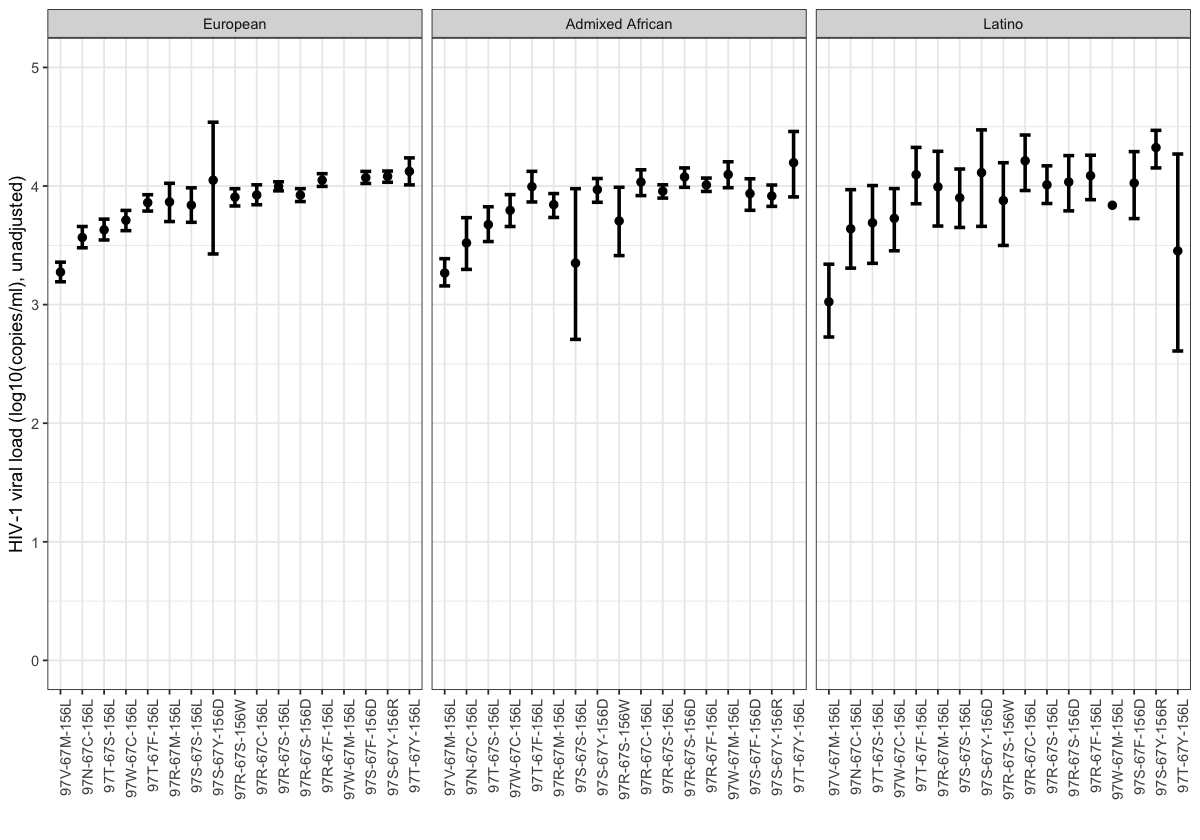

In [53]:
plt.df$pop <- factor(plt.df$pop,levels=c("eur","aa","lat"))

p <- ggplot(plt.df %>% filter(present==1), 
            aes(reorder(res,vl,FUN=median),y=vl)) 
#p <- p +  geom_boxplot(outlier.shape = NA) + theme_bw() 
p <- p  + stat_summary(fun.data = mean_cl_boot, geom = "errorbar", aes(width=0.5),colour = "black", size=1) + 
  stat_summary(fun.y = mean, geom = "point", colour = "black",size=2)
#p <- p + geom_violin()+ theme_bw()

# New facet label names for populations
pop.labs <- c("Admixed African", "European","Latino")

names(pop.labs) <- c("aa", "eur","lat")
p <- p + facet_grid(~pop,labeller = labeller(pop=pop.labs)) + theme_bw() + ylim(0,5)

p + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
  xlab("") + ylab("HIV-1 viral load (log10(copies/ml), unadjusted)")

ggsave("../figs/SF22_haplotype_spVL.png", height = 8, width = 12)


## multi-ethnic amino acid effect size (SF23)

Warning message:
“Removed 36 rows containing missing values (geom_errorbar).”
Warning message:
“Removed 33 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 33 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 33 rows containing missing values (geom_point).”
Warning message:
“Removed 36 rows containing missing values (geom_errorbar).”
Warning message:
“Removed 33 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 33 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 33 rows containing missing values (geom_point).”


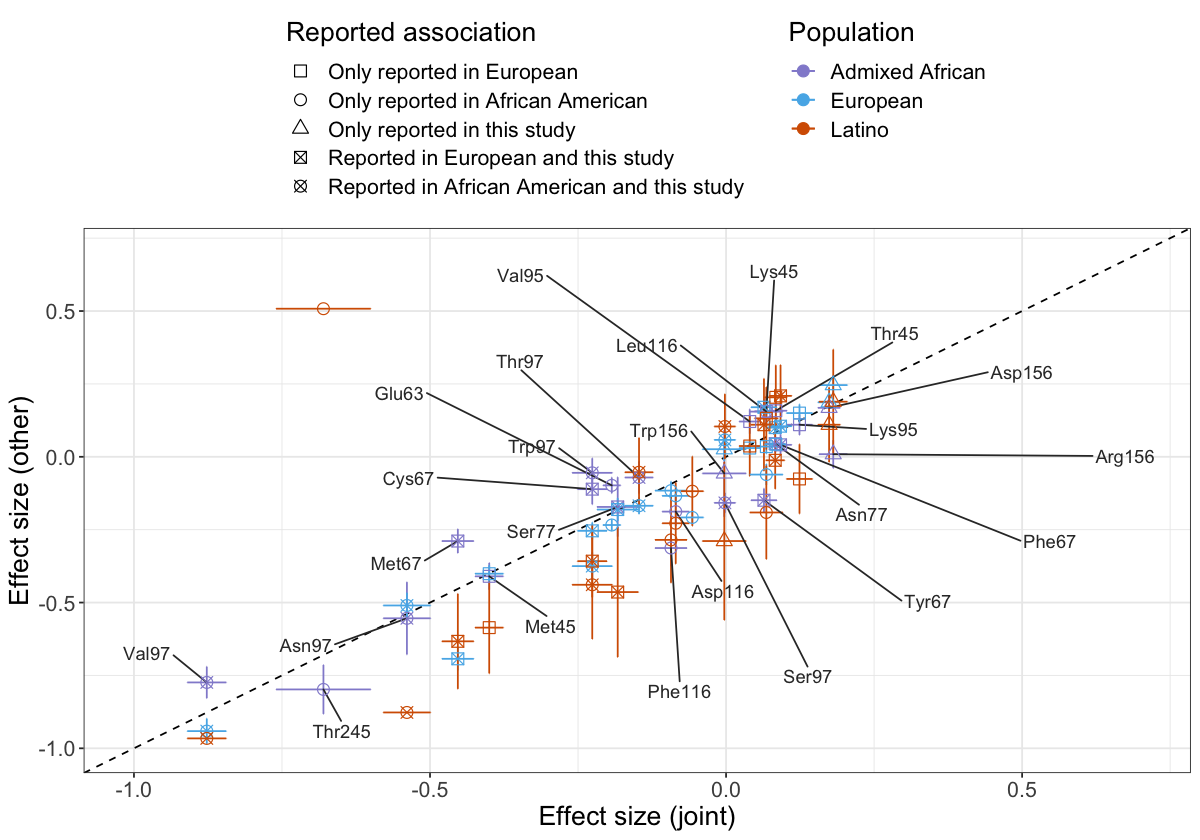

In [55]:
df <-read.table("../data/HIV_AA_summary.txt",h=T,stringsAsFactors = F)

df$label <- paste(df$aa_name,df$res,sep="")
df$reported <- paste(df$Current,df$McLaren_2012_AA,df$McLaren_2015_Euro,sep="")

df.plt = data.frame(AA = c(df$label,rep("", nrow(df)), rep("", nrow(df))),
                x = rep(df$joint_beta, 3),
                x.se = rep(df$joint_se, 3),
                y = c(df$aa_beta, df$eur_beta, df$lat_beta),
                y.se = c(df$aa_se, df$eur_se, df$lat_se),
                pop = rep(c("AA", "EUR" ,"LAT"), each = nrow(df)),
                reported = rep(df$reported,3))

plt =
  df.plt %>% # filter(reported=="100" | reported=="110"| reported=="101") %>%
  ggplot(aes(x, y, shape = as.factor(reported), colour=pop)) +
  geom_abline(slope = 1, intercept = 0, linetype="dashed") +
  geom_errorbar(aes(ymin = y - y.se, ymax = y + y.se)) +
  geom_errorbarh(aes(xmin = x - x.se, xmax = x + x.se)) +
  geom_text_repel(aes(label = AA), show.legend = F, box.padding = 1.5, col = "grey20") +
  geom_point(size=3) +
  xlab('Effect size (joint)') +ylab('Effect size (other)')+
  theme_bw() +
  theme(text = element_text(size = 16))


pop_colors <- c("#938dd2","#56B4E9","#D55E00")
pop_labels <- c("Admixed African","European","Latino")


plt + xlim(-1,0.7) + ylim(-1,0.7) +
  scale_color_manual(values=pop_colors,
                    labels=pop_labels,
                    name = "Population") +
  scale_shape_manual(values=c(0,1,2,7,13,18),labels = c("Only reported in European",
                                                     "Only reported in African American",
                                                     "Only reported in this study",
                                                     "Reported in European and this study",
                                                    "Reported in African American and this study",
                                                   "ALL"),
                     name = "Reported association") +
  theme(legend.position = "top",legend.direction = "vertical")


ggsave("../figs/SF23_HIV_aa_comparison.pdf",height=8,width=8)


## conditional analysis of previous signals (SF24)

In [62]:
aa.manhattan <- function(df = assoc, showxlab = TRUE,  showylab = FALSE, hlight=c("B-97"),
                         nudge_value = -20,eurhlight=eur_aa,aahlight=afr_aa){
    df.assoc <- NULL
    genes <- c("A","C","B","DRB1","DQA1","DQB1","DPA1","DPB1")
    for (gene in genes){
        assoc <- df %>% filter(grepl("AA_",AA_ID)) %>% na.omit() %>% 
            select(GENE,AA_POS,POS,PVALUE, SNP) %>%  group_by(GENE) %>% arrange(AA_POS)
        df1 <- assoc
        df.tmp <- df1[df1$GENE==gene, ]
        df.tmp$BP <- abs(df.tmp$AA_POS - df.tmp$AA_POS[1] )
        df.assoc <- rbind(df.assoc, df.tmp)
    }

    df.tmp <- df.assoc %>% 
        # compute gene length
        group_by(GENE) %>% mutate(rowID = 1:n()) 

    df.assoc <- df.tmp %>% summarise(gene_len=length(BP) ) %>% arrange(genes) %>%
        # calcuate cumulative positoin of each gene
            mutate(tot = cumsum(gene_len) - gene_len + 50) %>%

        # add info
        left_join(df.tmp,., by=c("GENE"="GENE")) %>%

        # Add a cumulate position of each amino acid
        arrange(GENE,rowID) %>% mutate(BPcum = tot + rowID) %>%
    
        # Add highlight and annotation information
        mutate( is_highlight=ifelse(SNP %in% hlight, "yes", "no")) %>%
        mutate( is_annotate=ifelse(SNP %in% hlight, "yes", "no")) %>%
    
        # Add highlight and annotation information European
      mutate( is_highlight_eur=ifelse(SNP %in% eurhlight, "yes", "no")) %>%
      mutate( is_annotate_eur=ifelse(SNP %in% eurhlight, "yes", "no")) %>%
    
        # Add highlight and annotation information from African American reported value
        mutate( is_highlight_aa=ifelse(SNP %in% aahlight, "yes", "no")) %>%
        mutate( is_annotate_aa=ifelse(SNP %in% aahlight, "yes", "no"))
  
    
    axisdf <- df.assoc %>% group_by(GENE) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>% arrange(genes)

    p <- ggplot(df.assoc, aes(x = BPcum, y = -log10(PVALUE), size = -log10(PVALUE))) + 
    geom_point( shape = 23)
    
    ymax <- max(-log10(df.assoc$PVALUE))*1.5
    p <- p + scale_fill_manual( values = gene_colors) + 
        scale_x_continuous( label = genes, breaks= axisdf$center ) +
        labs(x = "Amino acid positions") + 
        scale_y_continuous(limits=c(0,ymax), breaks = scales::pretty_breaks(n=4))

    # Add highlighted points
    p <- p + geom_point(data=subset(df.assoc, is_highlight=="yes"), fill="darkred",size =5, pch=23) 

    p <- p + geom_point(data=subset(df.assoc, is_highlight_aa=="yes"), fill=pop_colors[1],size =5, pch=23) +
     geom_point(data=subset(df.assoc, is_highlight_eur=="yes"), fill=pop_colors[3], size = 5, pch=23) 
    p <- p + 
        # Add label using ggrepel to avoid overlapping
        geom_text_repel(data=df.assoc[df.assoc$is_annotate=="yes",], 
                     aes(label=as.factor(SNP)), size=6,
                        nudge_x = -nudge_value, segment.size = 0.2, show.legend = FALSE) 
    
    p <- p + 
    geom_text_repel(data=df.assoc[df.assoc$is_annotate_aa=="yes",], 
                     aes(label=as.factor(SNP)), size=6,
                        nudge_x = nudge_value, segment.size = 0.2, show.legend = FALSE) +
    
    geom_text_repel(data=df.assoc[df.assoc$is_annotate_eur=="yes",], 
                     aes(label=as.factor(SNP)), size=6,
                        nudge_x = - nudge_value, segment.size = 0.2, show.legend = FALSE) 
    
    # add genome-wide threshold
    p <- p + geom_hline(yintercept = -log10(5e-8),linetype="dashed", color="black")
    # whether needs the xlabs
    if(showxlab == TRUE){
        p <- p + theme(legend.position = "none") 
    }else{
        p<- p + theme(legend.position = "none",axis.title.x = element_blank(), axis.text.x = element_blank())

    }
    if(showylab == TRUE){
        p <- p + theme(legend.position = "none") + ylab("-log10(P)")
    }else{
        p <- p + theme(legend.position = "none",axis.title.y = element_blank()) 

    }
}

In [63]:
# previously reported amino acid positions
eur_aa <- c("B-97", "B-67", "A-77", "B-45", "A-95")
afr_aa <- c("B-97"  ,"B-245", "B-116", "B-63" )



AA_ID GENE AA_POS POS DOF SS PVALUE PVALUE_HET AA N_AA N_HAPLO N_HAPLO_ADD
     PctExp SNP

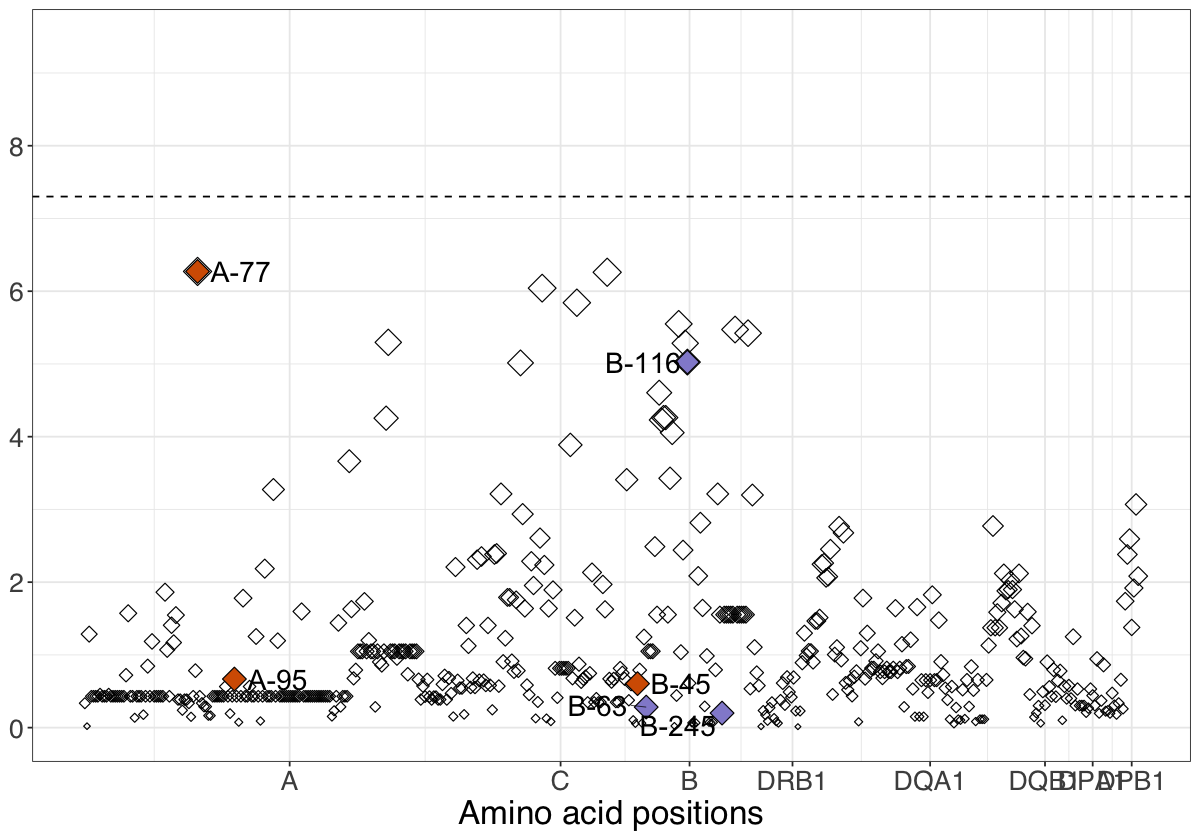

In [64]:
# condition on four amino acid positions identified in this study (B97, B67, B156, A77)
df <- read.table("../data/all.4th.txt",h=T,stringsAsFactors = F)
assoc <- df[ df$AA_POS>0,]
assoc$SNP <- paste(assoc$GENE,assoc$AA_POS,sep="-")
x <- na.omit(assoc)
x[x$PVALUE<5e-8,] %>% filter(grepl("AA_",AA_ID))

p.current <- aa.manhattan(df = assoc,eurhlight=eur_aa,aahlight=afr_aa)

p.current

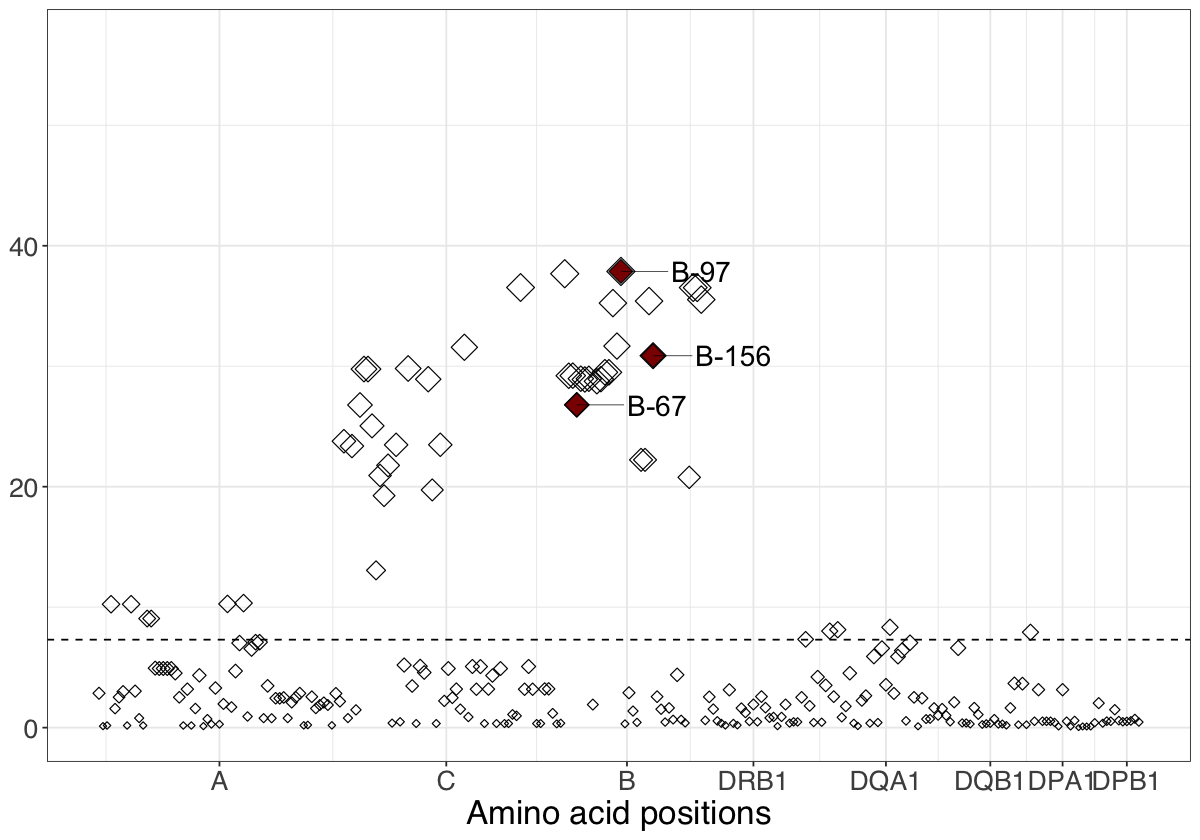

In [65]:
# condition on four amino acid positions identified in other sutides only (B45, B63, B116, A95)
current_aa <- c("B-97"  ,"B-156", "B-67" )

df <- read.table("../data/all.previous.txt",h=T,stringsAsFactors = F)
assoc <- df[ df$AA_POS>0,]
assoc$SNP <- paste(assoc$GENE,assoc$AA_POS,sep="-")
x <- na.omit(assoc)

p.previous <- aa.manhattan(df = assoc,hlight=current_aa,aahlight=NULL,eurhlight=NULL)

p.previous

In [66]:
# combine two plots

prow <- plot_grid( p.current + theme(legend.position="none"),
           p.previous + theme(legend.position="none"),
           align = 'vh',
           labels = c("(a)", "(b)"),
           hjust = .2,
           nrow = 1
           )
y.grob <- textGrob(expression(-log10(P[omnibus])), 
                   gp=gpar(fontface="bold", col="black", fontsize=20), rot=90, vjust = .3)

#add to plot


png("../figs/SF24_hiv_conditional_previous_aas.png", height = 7, width = 12, units= "in", res=200)
    
grid.arrange(arrangeGrob(prow, left = y.grob))

dev.off()

pdf 
  2